# Desarrollo de un Sistema de Aprendizaje Automático para el Reconocimiento de Actividad Humana con Smartphones

Este proyecto busca aplicar las técnicas de aprendizale automático supervisado aprendidas a lo largo del curso al dataset [Human Activity Recognition database](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones/data).

El dataset utilizado contiene lecturas 30 individuos, tomadas a un ratio de 50 kHz por los sensores embebidos de sus teléfonos móviles. Las medidas concretas son:
- Aceleración lineal triaxial del acelerómetro.
- Velocidad angular triaxial del giroscopio.

A partir de estas medidas base de acelerómetro y giroscopio, los creadores del dataset han aplicado una serie de preprocesamientos para crear nuevos atributos que faciliten la predición. Estos se especificarán con detalle más adelante.

El dataset se compone de 563 columnas, de las cuales 561 son un vector de atributos con distintas mediciones de variables de tiempo y frecuencia, y las otras 2 son la actividad y el ID del sujeto que la llevó a cabo.
El número de instancias es de 10299, con un tamaño total de 26MB.

Cabe destacar que el conjunto de datos no contiene datos nulos, un gran desbalance de clases ni una alta presencia de outliers, y ha sido previamente particionado en conjuntos de entrenamiento y test, formados por el 70% y 30% de las personas participantes en la recogida de datos, respectivamente.

Sobre este dataset se entrenarán modelos de clasificación multiclase con el objetivo de clasificar las actividades realizadas independientemente del sujeto, dados los atributos de los sensores previamente mencionados. Las clases a predecir son:

- `WALKING`
- `WALKING_UPSTAIRS`
- `WALKING_DOWNSTAIRS`
- `SITTING`
- `STANDING`
- `LAYING`

Se han utilizado modelos de **k-Nearest Neighbours**, **Support Vector Machine** (con distintos kernels) y **Árboles de decisión** para la predicción, y se comprobará que modelo logra un mejor rendimiento sobre el conjunto de test.

Para la evaluación del modelo se han presentado matrices de confusión que permitan ver los resultados de cada modelo en cada clase, y se han utilizado las siguientes métricas:

- **Exactitud (accuracy)**: aciertos sobre el total de muestras. Elegida ya que funciona correctamente con datasets balanceados, como es el caso en este.

- **F1-score weighted**: media harmónica de *recall* y *precision* calculada de forma independiente para cada clase, y luego se calcula la media ponderada.

  Indicada para situaciones con desbalandeo de clases. El balance de clases nunca es perfecto, y aunque en este dataset es bueno , se ha elegido esta métrica para comparar con los resultados de accuracy y ver si el desbalance presente afecta al rendimiento de los modelos.

- **AUC macro**: media usando One-Vs-Rest del área bajo la curva ROC. Indica lo bueno que es un clasificador en base a la tasa de falsos positivos y la de verdaderos positivos.

  Útil para poder tomar decisiones de modificación de hiperparámetros sobre clasificadores parametrizados, como por ejemplo modificar $C$ en una SVM para permitir mayor o menor tolerancia a errores.

# Estructura del proyecto:
1. [Fases a completar](#fases-a-completar)
2. [texto](#texto)
2. [texto](#texto)
2. [texto](#texto)
2. [texto](#texto)
2. [texto](#texto)
2. [texto](#texto)

# Fases a completar <a name="fases-a-completar"></a>

1. Análisis y exploración de los datos

2. Escalado estandarización de los datos
  - Mantener separado train y test! Normalizar test una vez se ha seleccionado train.

3. Reducción de dimensionalidad
  - Buscar mejor método. Probar sin reducción también.
  - LDA, PCA, t-SNE
  - PCA + t-SNE: primero PCA reduce mucho y luego t-SNE el resultado final

4. Crear Pipeline con los pasos anteriores

5. Para cada uno de los siguientes modelos:
  1. Árboles de decisión
  2. k-NN
  3. Máquinas de soporte vectorial con distintos kernels.
  4. Si da tiempo probar con modelos más complejos / ensembre learning

  Hay que hacer los siguientes pasos:
  1. Baseline: modelo sin hiperparámetros para comparación. Comprobar overfitting / underfitting.
  2. Elegir unna técnica de optimización de hiperparámetros y los hiperparámetros a optimizar, ejecutar la búsqueda para cada uno de ellos. También elegir el número de folds para cross-validation.
  3. Comprobar overfitting / underfitting para los mejores hiperparámetros encontrados.

6. Evaluación y selección de modelos:
  - Crear matriz de confusión y classification report para cada modelo
  - Crear (posiblemente) para combinaciones distintas de preprocesado?
  - Crear report con Curva ROC y AUC.
  - Identificar el mejor modelo.

7. Conclusiones y resultados


In [ ]:
# Dataset
# https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones/data

# local import se falla google drive
'''from google.colab import files
upload = files.upload()'''
pass

from multiprocessing import cpu_count
cores = cpu_count()
cores

2

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from time import perf_counter

from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, label_binarize
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.manifold import TSNE

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from skopt.plots import plot_evaluations, plot_objective, plot_convergence
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
  roc_auc_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay)

STATE = 42

In [ ]:
# import dataset from drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Análisis y exploración de los datos

In [ ]:
# read the train split in csv format
train = pd.read_csv('/gdrive/MyDrive/UNIVERSIDADE/3º CURSO/APAU/train.csv')
train

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0              0.288585          -0.020294          -0.132905   
1              0.278419          -0.016411          -0.123520   
2              0.279653          -0.019467          -0.113462   
3              0.279174          -0.026201          -0.123283   
4              0.276629          -0.016570          -0.115362   
...                 ...                ...                ...   
7347           0.299665          -0.057193          -0.181233   
7348           0.273853          -0.007749          -0.147468   
7349           0.273387          -0.017011          -0.045022   
7350           0.289654          -0.018843          -0.158281   
7351           0.351503          -0.012423          -0.203867   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0            -0.995279         -0.983111         -0.913526         -0.995112   
1            -0.998245         -0.975300         -0.960322         -0.998807   
2            -0.995380         -0.967187         -0.978944         -0.996520   
3            -0.996091         -0.983403         -0.990675         -0.997099   
4            -0.998139         -0.980817         -0.990482         -0.998321   
...                ...               ...               ...               ...   
7347         -0.195387          0.039905          0.077078         -0.282301   
7348         -0.235309          0.004816          0.059280         -0.322552   
7349         -0.218218         -0.103822          0.274533         -0.304515   
7350         -0.219139         -0.111412          0.268893         -0.310487   
7351         -0.269270         -0.087212          0.177404         -0.377404   

      tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
0            -0.983185         -0.923527         -0.934724  ...   
1            -0.974914         -0.957686         -0.943068  ...   
2            -0.963668         -0.977469         -0.938692  ...   
3            -0.982750         -0.989302         -0.938692  ...   
4            -0.979672         -0.990441         -0.942469  ...   
...                ...               ...               ...  ...   
7347          0.043616          0.060410          0.210795  ...   
7348         -0.029456          0.080585          0.117440  ...   
7349         -0.098913          0.332584          0.043999  ...   
7350         -0.068200          0.319473          0.101702  ...   
7351         -0.038678          0.229430          0.269013  ...   

      fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                           -0.710304                    -0.112754   
1                           -0.861499                     0.053477   
2                           -0.760104                    -0.118559   
3                           -0.482845                    -0.036788   
4                           -0.699205                     0.123320   
...                               ...                          ...   
7347                        -0.880324                    -0.190437   
7348                        -0.680744                     0.064907   
7349                        -0.304029                     0.052806   
7350                        -0.344314                    -0.101360   
7351                        -0.740738                    -0.280088   

      angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                                 0.030400                         -0.464761   
1                                -0.007435                         -0.732626   
2                                 0.177899                          0.100699   
3                                -0.012892                          0.640011   
4                                 0.122542                          0.693578   
...                                    ...                               ...   
7347                              0.829718                

In [ ]:
# read the test split
test = pd.read_csv('/gdrive/MyDrive/UNIVERSIDADE/3º CURSO/APAU/test.csv')
test

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0              0.257178          -0.023285          -0.014654   
1              0.286027          -0.013163          -0.119083   
2              0.275485          -0.026050          -0.118152   
3              0.270298          -0.032614          -0.117520   
4              0.274833          -0.027848          -0.129527   
...                 ...                ...                ...   
2942           0.310155          -0.053391          -0.099109   
2943           0.363385          -0.039214          -0.105915   
2944           0.349966           0.030077          -0.115788   
2945           0.237594           0.018467          -0.096499   
2946           0.153627          -0.018437          -0.137018   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0            -0.938404         -0.920091         -0.667683         -0.952501   
1            -0.975415         -0.967458         -0.944958         -0.986799   
2            -0.993819         -0.969926         -0.962748         -0.994403   
3            -0.994743         -0.973268         -0.967091         -0.995274   
4            -0.993852         -0.967445         -0.978295         -0.994111   
...                ...               ...               ...               ...   
2942         -0.287866         -0.140589         -0.215088         -0.356083   
2943         -0.305388          0.028148         -0.196373         -0.373540   
2944         -0.329638         -0.042143         -0.250181         -0.388017   
2945         -0.323114         -0.229775         -0.207574         -0.392380   
2946         -0.330046         -0.195253         -0.164339         -0.430974   

      tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
0            -0.925249         -0.674302         -0.894088  ...   
1            -0.968401         -0.945823         -0.894088  ...   
2            -0.970735         -0.963483         -0.939260  ...   
3            -0.974471         -0.968897         -0.938610  ...   
4            -0.965953         -0.977346         -0.938610  ...   
...                ...               ...               ...  ...   
2942         -0.148775         -0.232057          0.185361  ...   
2943         -0.030036         -0.270237          0.185361  ...   
2944         -0.133257         -0.347029          0.007471  ...   
2945         -0.279610         -0.289477          0.007471  ...   
2946         -0.218295         -0.229933         -0.111527  ...   

      fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                           -0.705974                     0.006462   
1                           -0.594944                    -0.083495   
2                           -0.640736                    -0.034956   
3                           -0.736124                    -0.017067   
4                           -0.846595                    -0.002223   
...                               ...                          ...   
2942                        -0.750809                    -0.337422   
2943                        -0.700274                    -0.736701   
2944                        -0.467179                    -0.181560   
2945                        -0.617737                     0.444558   
2946                        -0.436940                     0.598808   

      angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                                 0.162920                         -0.825886   
1                                 0.017500                         -0.434375   
2                                 0.202302                          0.064103   
3                                 0.154438                          0.340134   
4                                -0.040046                          0.736715   
...                                    ...                               ...   
2942                              0.346295                

## Descripción de los atributos del dataset

Este dataset contiene una serie de atributos específicos obtenidos mediante ingeniería de atributos por sus autores. Una explicación comleta se puede leer en el [paper original](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf)

A continuación se hace un resumen de los procesamientos que se han realizado sobre las lecturas originales para obtener el dataset:

1. Se ha separado la aceleración de la gravedad de las lecturas del acelerómetro utilizando un filtro de paso bajo.

2. Se han creado nuevas variables de aceleración angular, jerk del acelerómetro (cambio en la aceleración, segunda derivada de la velocidad) y magnitud euclidiana de todas las variables hasta ahora mencionadas.

3. Una vez hecho esto, para las lecturas de acelerómetro, gravedad y giroscopio se han creado dos columnas: una sobre la variable temporal y otra sobre la frecuencia. Las variables finales se pueden ver en la siguiente imagen:

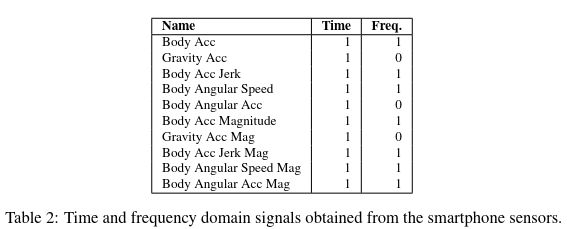




4. Finalmente, sobre cada una de estas se ha aplicado un nuevo mapeo de características, utilizando las siguientes medidas:

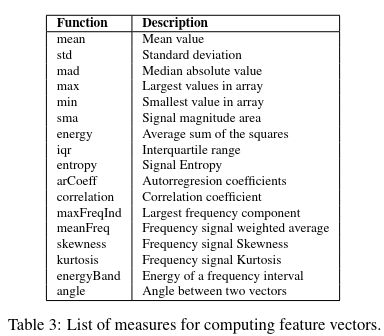

## Splitting del dataset

Creamos un vector de clases y un vector de atributos para entrenamiento y test, y eliminamos los datos que no aportarán información al modelo.

Los IDs no tienen poder predictivo ya que el objetivo es predecir la actividad para una persona cualquiera. Manteniéndolos en el dataset favoreceríamos que se detectasen personas específicas. Además, los conjuntos de entrenamiento y test están compuestos por distintos sujetos.

También se crea una división de holdout para los casos en los que se compare algún modelo sin hacer cross validation.

In [ ]:
X_train = train.drop(['subject', 'Activity'], axis=1)
y_train = train['Activity']

X_test = test.drop(['subject', 'Activity'], axis=1)
y_test = test['Activity']

X_holdout_train, X_val, y_holdout_train, y_val = \
  train_test_split(X_train, y_train, test_size=0.15, random_state=STATE) # esto se usará más adelante en ocasiones

In [ ]:
X_train.shape, X_test.shape, X_train.columns, list(y_train.unique())

((7352, 561),
 (2947, 561),
 Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
        'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
        'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
        'tBodyAcc-max()-X',
        ...
        'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
        'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
        'angle(tBodyAccJerkMean),gravityMean)',
        'angle(tBodyGyroMean,gravityMean)',
        'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
        'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
       dtype='object', length=561),
 ['STANDING',
  'SITTING',
  'LAYING',
  'WALKING',
  'WALKING_DOWNSTAIRS',
  'WALKING_UPSTAIRS'])

Todos los atributos del dataset son floats, y comprobaremos más adelante su rango.

## Comprobando la presencia de nulos en el dataset

Comprobaremos si el dataset tiene nulos. Esto es importante ya que ciertos algoritmos no trabajan bien con ellos, mientras que otros sí.

In [ ]:
# creamos un dataframe de juguete para ver si la función va bien
data = {'Name': [np.nan, 'nick', np.nan, 'jack'],
        'Age': [np.nan, 30, 19, 18]}
df = pd.DataFrame(data)

def has_nulls(df, verbose=True):
  '''Checks if the dataset has null values. Shows where with `verbose=True`'''
  hasNAN = df.isnull().sum()
  hasNAN = hasNAN[hasNAN > 0]
  hasNAN = hasNAN.sort_values(ascending=False)
  print(hasNAN, end="\n\n")

  return hasNAN.size > 0

has_nulls(df)
# ahora comprobamos si nuestro dataset real tiene nulos
nulls_train = has_nulls(X_train)
nulls_test = has_nulls(X_test)
nulls_train, nulls_test

Name    2
Age     1
dtype: int64

Series([], dtype: int64)

Series([], dtype: int64)



(False, False)

Observamos que el dataset no contiene nulos, ya que la función devuelve `False`.

## Comprobando la normalización de los datos

En la preview del dataset podemos observar que las distribuciones parecen estar siempre en valores fijos entre $[-1, 1]$.
Crearemos una función para comprobar si esto es así.

Si los datos están normalizados, esto nos ahorrará mucho trabajo a la hora de realizar el preprocesamiento.

In [ ]:
# check some of the instances
instance0_0_A = X_train['tBodyAcc-mean()-X'][1]
instance0_0_B = X_train.iloc[1, 0]
assert instance0_0_A == instance0_0_B
print(instance0_0_A)
print(instance0_0_B)

instance0_0_A = X_train['tBodyAcc-mean()-Y'][0]
instance0_0_B = X_train.iloc[0, 1]
print(instance0_0_A)
print(instance0_0_B)
assert instance0_0_A == instance0_0_B

0.27841883
0.27841883
-0.020294171
-0.020294171


In [ ]:
# creamos un dataframe de juguete para ver si la función va bien
data = {'attr1': [0.1]*7,
        'attr2': [0.1, 0, 3, 0.999, -0.9, 1, -4]}
df = pd.DataFrame(data)

#comprobar los máximos y mínimos de cada columna
# queremos saber los rangos de cada elemento para saber si ya estan normalizados
def check_out_of_range(df, minval, maxval):
  """Checks which columns in a datarfame are out of the given numeric range."""
  out_of_range = dict()
  for column in df.columns:
    min = df[column].min()
    max = df[column].max()
    if min < minval or max > maxval:
      out_of_range[column] = (min, max)

  print("Cols out of range: ", out_of_range) if bool(out_of_range) else print('No cols out of range', end="\n\n")

print("Test dataset: ")
check_out_of_range(df, -1, 1)
print("Human Activity Recognition dataset: ")
check_out_of_range(X_train, -1, 1)

Test dataset: 
Cols out of range:  {'attr2': (-4.0, 3.0)}
Human Activity Recognition dataset: 
No cols out of range



Verificamos que el dataset está normalizado en todas sus dimensiones en el rango $[-1,1]$.

## Sobre las distribuciones de los atributos
Los atributos del dataset, aunque normalizados y procesados, no comparten distribuciones. Ciertos atributos si lo hacen, como por ejemplo los derivados del cálculo de la desviación estándar, o las medias de aceleración del cuerpo para los ejes X, Y, Z.

No se deberían aplicar al dataset modelos y procesamientos que dependan de, o asuman, una distribución fija de los datos. Si se quiere hacer esto, habría que hacerlo sobre un subconjunto de atributos seleccionado.

Vemos algunas de las distribuciones del dataset en la preview de su página de Kaggle:

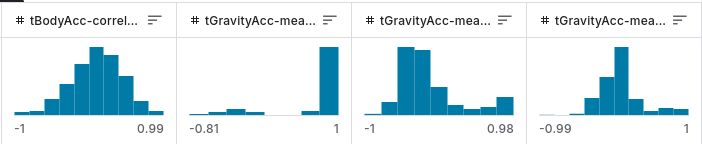

## Usando el Local Outlier Factor para determinar la proporción de outliers en el dataset

https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
Es importante también determinar si el dataset contiene ruído o no. Un exceso de outliers puede significar un exceso de ruído en la toma de datos, y requerir preprocesado adicional.

Los autores del dataset han realizado un preprocesado extenso pero es mejor comprobarlo. Para ello usaremos el *Local Outlier Factor*.
El LOF permite ver el grado en el que las muestras del dataset son outliers:

> _The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. It is the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors._

> _The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_  _close to -1), while outliers tend to have a larger LOF score._

Los valores para LOF vienen recomendados por la guía de usuario de Scikit Learn. 20 es un valor estándar para `n_neigbors`. El parámetro `contamination` determina el umbral a partir del cual se considera una instancia outlier. Si no se especifica, el algoritmo lo determina de forma automática. En este caso, la especificación de 0.01 (1%) es mucho más generosa que la del algoritmo, que considera muchos menos outliers.

In [ ]:
# we set n_neigbors to the standard recommended value 20
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
clf.fit_predict(X_train)
clf_auto = LocalOutlierFactor(n_neighbors=20)
clf_auto.fit_predict(X_train)
# see some of the results
X_scores = clf.negative_outlier_factor_
print(X_scores.shape)
print(X_scores)

(7352,)
[-1.51250875 -1.04592516 -1.02306275 ... -1.02502088 -1.02111953
 -1.00732075]


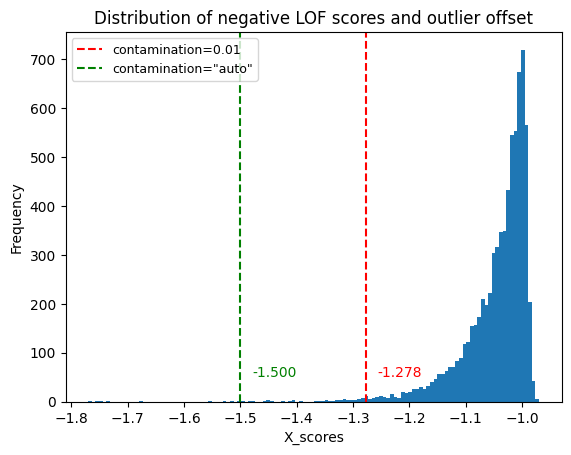

In [ ]:
# plot distribution of X_scores and show where the thresholds lie
plt.hist(X_scores, bins='auto')

# draw line at clf.offset_
plt.axvline(x=clf.offset_, color='r', linestyle='--')
plt.axvline(x=clf_auto.offset_, color='g', linestyle='--')
plt.xlabel('X_scores')
plt.ylabel('Frequency')
plt.title(f'Distribution of negative LOF scores and outlier offset')
# set legend for lines
plt.legend(['contamination=0.01', 'contamination="auto"'], fontsize=9)

# add text annotations for offset values
ymin, ymax = plt.ylim()
plt.text(clf.offset_ + 0.1, ymin + 50, f'{clf.offset_:.3f}', color='r', ha='right')
plt.text(clf_auto.offset_ + 0.1, ymin + 50, f'{clf_auto.offset_:.3f}', color='g', ha='right')

plt.show()

Observamos que la proporción de outliers es muy pequeña con respecto al total. No deberían resultar un problema a la hora de entrenar los algoritmos.

## Comprobando el balance de clases y datos en el dataset

Comprobaremos también el balance de clases con respecto al dataset. Esto es importante ya que clases con un desbalance muy pronunciado pueden sesgar ciertos algoritmos hacia las clases más presentes.

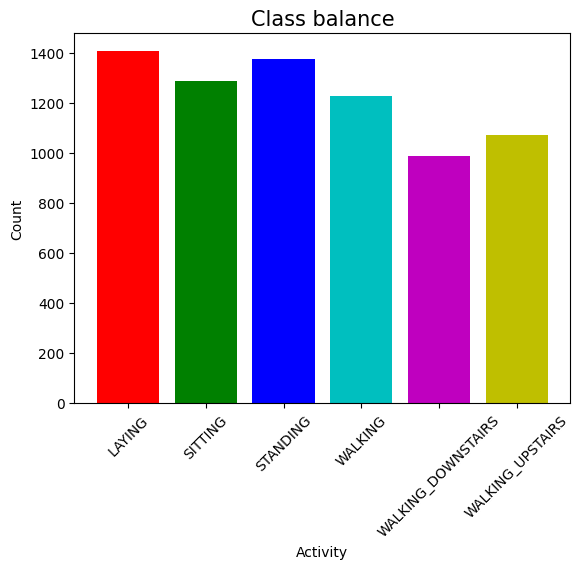

In [ ]:
# check class inbalances with a plot
# Get the unique activities and their counts
activities, counts = np.unique(y_train, return_counts=True)

plt.bar(activities, counts, color=['r', 'g', 'b', 'c', 'm', 'y'])
plt.title('Class balance', fontsize=15)
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Visualización de los datos

Inspirándome en este [cuaderno de Exploratory Data Analysis](https://www.kaggle.com/code/abheeshthmishra/eda-of-human-activity-recognition) decidí hacer una serie de visualizaciones de los datos para conocer su distribución.

La idea es por un lado visualizar y comparar los datos de algunos atributos específicos, y por otro proyectar el conjunto de datos a un número de dimensiones que se pueda visualizar y ver si se puede extraer alguna conclusión.



## Intuiciones acerca de la distribución de los datos

Lo primero es graficar distribución de algunos de los datos más 'intuitivos', que no requieran conocimiento del dominio extenso, para hacerse una idea de las propiedades y características del dataset.

Decidí graficar 8 de las columnas del dataset:
- `tBodyAcc-mean()-X, Y, Z`: medias de las medidas del acelerómetro, muestreadas con una ventana deslizante fija de 2.56 segundos y solapamiento del 50%.
- `tBodyGyro-mean()-X, Y, Z`: media de las medidas del giroscopio,muestreadas con una ventana deslizante fija de 2.56 segundos y solapamiento del 50%.
- ` 'tBodyAccMag-mean()'`: media agregada de las medidas anteriores de acelerómetro.
- ` 'tBodyAccMag-mean()'`: media agregada de las medidas anteriores de giroscopio.

In [ ]:
def plot_density_for_classes(train, column, size=(9,6), cut_sides=False):
  fig, ax = plt.subplots(figsize=size)
  colors = plt.cm.tab10(np.linspace(0, 5))

  # iterate through unique activities and plot densities
  for i, activity in enumerate(train['Activity'].unique()):
    subset = train[train['Activity'] == activity]
    density = np.histogram(subset[column], bins=50, density=True)  # calculate density
    ax.plot(density[1][:-1], density[0], color=colors[i], label=activity)

  if cut_sides: # cut off the tails of some of the plots to better see distribution
    xmin, xmax = ax.get_xlim()
    xrange = xmax - xmin
    # reduce x-axis range by `cut_sides`% on each side
    ax.set_xlim(xmin + cut_sides * xrange, xmax - cut_sides * xrange)

  ax.legend()
  ax.set_xlabel(column)
  ax.set_ylabel('Density')
  ax.set_title(f'Density Plots of {column} by Activity')

  plt.show()

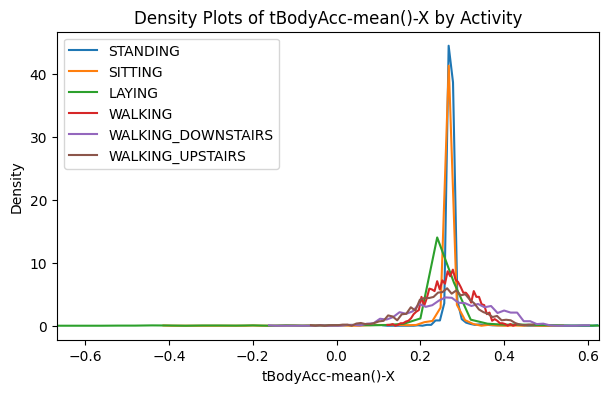

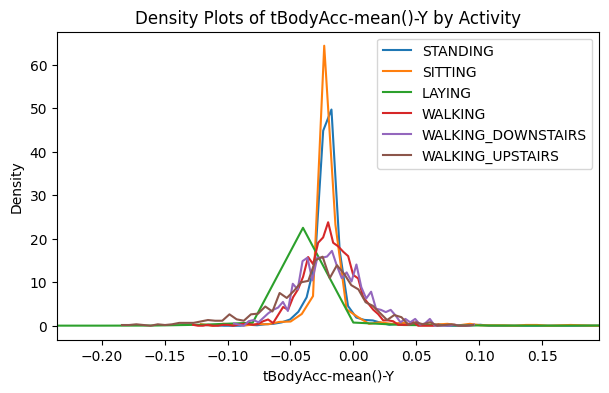

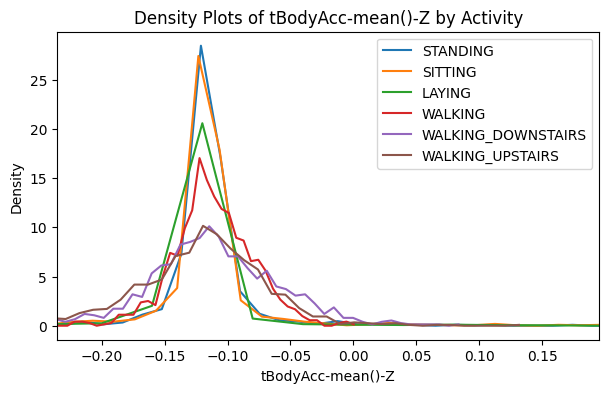

In [ ]:
plot_density_for_classes(train, 'tBodyAcc-mean()-X', size = (7,4), cut_sides=0.2)
plot_density_for_classes(train, 'tBodyAcc-mean()-Y', size = (7,4), cut_sides=0.4)
plot_density_for_classes(train, 'tBodyAcc-mean()-Z', size = (7,4), cut_sides=0.4)

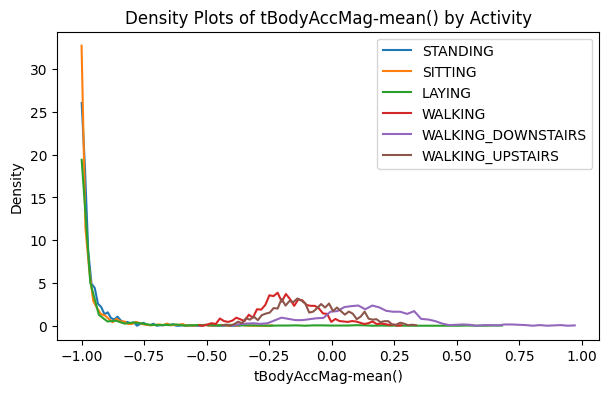

In [ ]:
plot_density_for_classes(train, 'tBodyAccMag-mean()', size = (7,4))

Lo más destacable de estas distribuciones es que se puede observar claramente que las actividades estáticas, como `STANDING`, `SITTING`, `LAYING`, tienen una distribución con valores de aceleración menos centrados que las actividades dinámicas; `WALKING`, `WALKING_DOWNSTAIRS`, `WALKING_UPSTAIRS`.

A nivel de clasificación esto podría indicar una separabilidad fácil entre estos dos grupos de características.

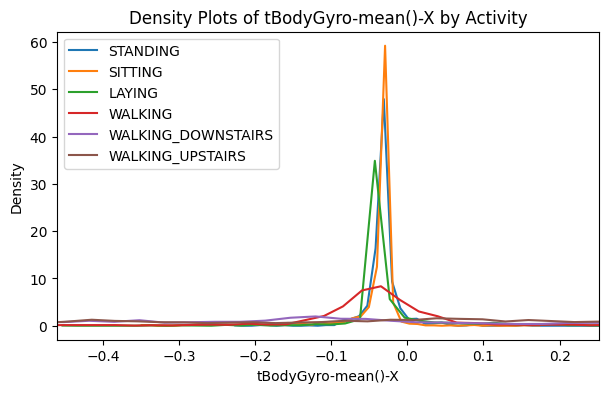

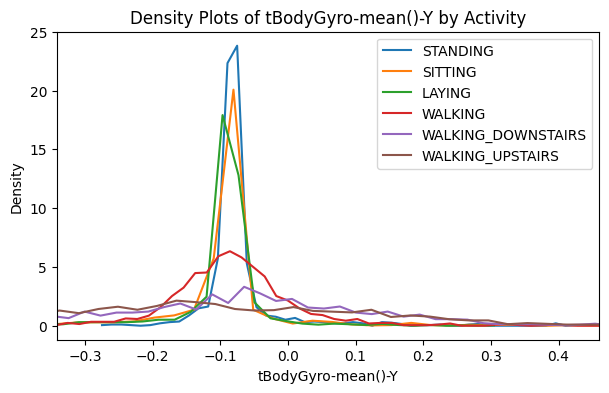

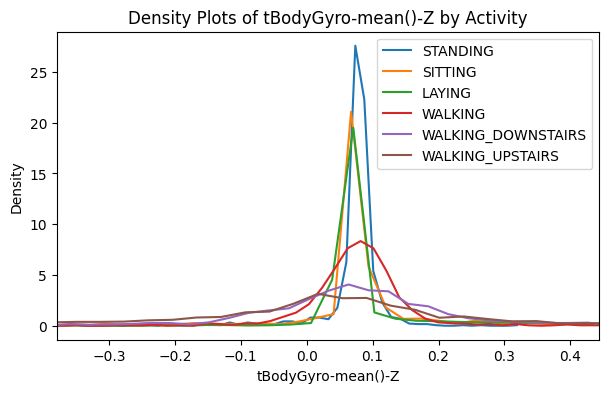

In [ ]:
plot_density_for_classes(train, 'tBodyGyro-mean()-X', size = (7,4), cut_sides=0.3)
plot_density_for_classes(train, 'tBodyGyro-mean()-Y', size = (7,4), cut_sides=0.3)
plot_density_for_classes(train, 'tBodyGyro-mean()-Z', size = (7,4), cut_sides=0.3)

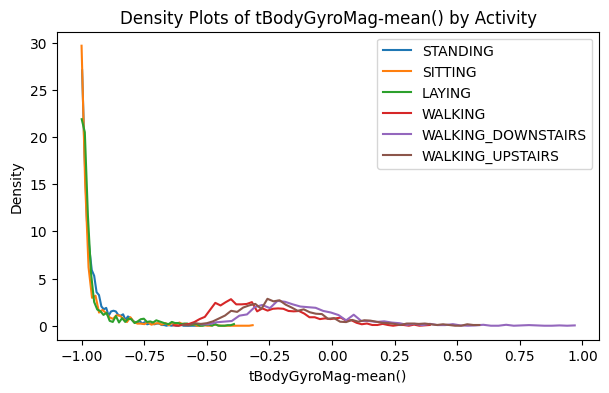

In [ ]:
plot_density_for_classes(train, 'tBodyGyroMag-mean()', size = (7,4))

De nuevo observamos una clara distinción entre las actividades estáticas y las actividades dinámicas. La diferencia es incluso más notable para las medidas del giroscopio.

## Visualización en menor dimensión

También inspirándome en el cuaderno anteriormente mencionado, decidí proporcionar una visión del conjunto de datos para comprobar la separabilidad, de las clases, y conocer que clases serán más complejas de separar.

Para ello utilicé el *t-distributed Stochastic Neighbor Embedding*, un método para visualización de datos de numerosas dimensiones.
Realiza una reducción de dimensionalidad no lineal creando una distribución de probabilidad que representa las similitudes entre muestras en un espacio de gran dimensión y uno de menor dimensión.

Como mantiene la estructura local de los datos, los puntos cercanos en el espacio original tenderán a estar próximos en el espacio reducido.
Esto permite realizar una "proyección" para visualizar los datos en 2 o 3 dimensiones.

A continuación se crea una función que permite la reducción de dimensionalidad de los datos aplicando t-SNE y usando distintas perplejidades (hiperparámetro de t-SNE, determina la desv. estándar de las distr. de prob. que usa):

In [ ]:
def reduce_dim_tsne(X, dims, perplexities):
  reduced_data = []
  for perplex in perplexities:
    #Aplicamos un método para reducir los datos a 3 dimensiones
    red_dim = TSNE(n_components=dims, random_state=STATE, perplexity=perplex)
    X_reduced = red_dim.fit_transform(X)
    reduced_data.append(X_reduced)

  return reduced_data

También creo una función para la representación en 2 o 3 dimensiones del dataset una vez se le ha aplicado la reducción de dimensionalidad:

In [ ]:
def plot_projection_2d_or_3d(X_list: list, y, dim, plot_size=(10,8)):
  """Función para visualizar proyecciones a partir de una lista de datos reducidos.

  Parámetros:
  - X_list: Lista de conjuntos de entrenamiento reducidos a 2 o 3 dimensiones.
  - y: Vector de clases que asigna colores a cada punto.
  - dim: Dimensión de los datos (2 o 3).
  """
  assert dim in [2, 3], "La dimensión debe ser 2 o 3"

  # create a map of activity names and their number and generate a targets vector from it
  names = {v: k for (k, v) in enumerate(list(y.unique()))}
  targets = [names[inst] for inst in y]
  # create a custom colormap of 5 colours
  custom_cmap = colors.ListedColormap(plt.cm.tab10(np.arange(6)))

  for X_reduced in X_list:
    # plot on 3d or 2d each reduced dataset
    if dim == 2:
      fig, ax = plt.subplots(figsize=plot_size)

      scatter = ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=targets,
        cmap=custom_cmap,
        s=2,
      )
    else:
      fig = plt.figure(1, figsize=plot_size)
      ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

      scatter = ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=targets,
        cmap=custom_cmap,
        s=1,
      )

    ax.set_title(f"Primeros {'2' if dim == 2 else '3'} componentes t-SNE")
    ax.set_xlabel("Primer componente")
    ax.xaxis.set_ticklabels([])  # no data on the edges as it's not informative
    ax.set_ylabel("Segundo componente")
    ax.yaxis.set_ticklabels([])
    if dim == 3:
      ax.set_zlabel("Tercer componente")
      ax.zaxis.set_ticklabels([])

    # Crear la leyenda para asociar colores a clases
    legend1 = ax.legend(
        scatter.legend_elements()[0], list(y.unique()), loc="best", title="Clases")

    ax.add_artist(legend1)
    plt.show()

(https://stackoverflow.com/questions/41602588/how-to-create-3d-scatter-animations)

In [ ]:
X_reduced_list = reduce_dim_tsne(X_train, 2, perplexities=(30,))

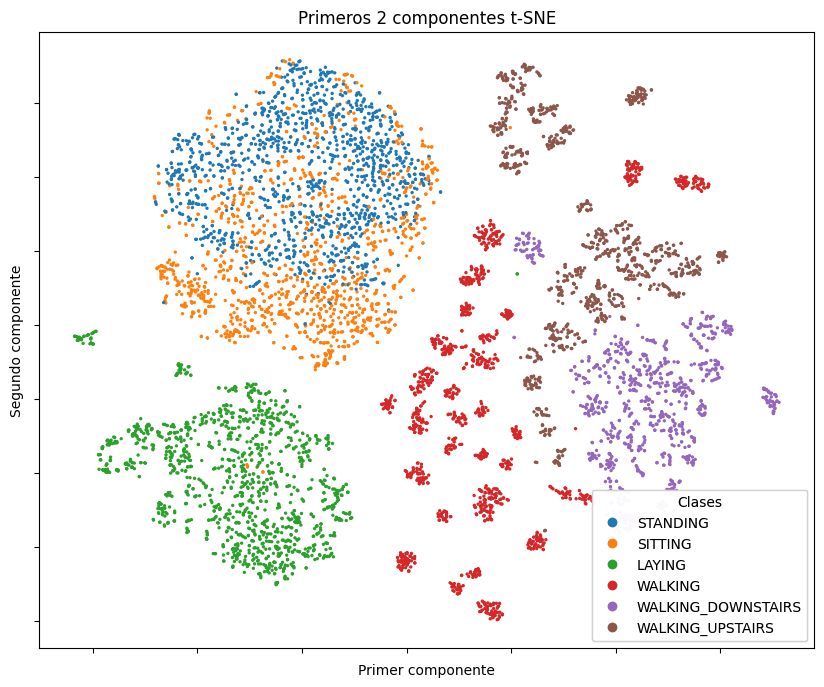

In [ ]:
plot_projection_2d_or_3d(X_reduced_list, y_train, 2)

Como podemos ver, la proyección refleja algunas de las propiedades que se intuían observando las distribuciones de los datos: hay una seperación entre muestras de actividades estáticas y en movimiento.

También se ve una clara separación entre estar `LAYING` y `SITTING` y `STANDING`, que se podría deber a la dirección distinta en la que incide la aceleración de la gravedad para cada una de ellas.
`SITTING` y `STANDING` son más diffíciles de separar, al menos en esta proyección, y las clases de movimiento tienen separación entre ellas aunque no parece tan simple.

Aunque esta proyección no refleja completamente la posible separación real de los datos en un número mayor de dimensiones, sí nos da una idea aproximada de qué clases serán más difíciles de separar en el problema, gracias a la proyección basada en probabilidades de t-SNE.

# Funciones utilizadas a lo largo del cuaderno

Para reducir la duplicación de código se crearon una serie de funciones que encapsulan ciertas funcionalidades que se requerirán a lo largo del cuaderno:

Estas están comentadas para facilirtar su comprensión, aunque en general actúan como *wrappers* de otras funciones.

In [ ]:
def analize_fitting_estimator(model : BaseEstimator, X_train, y_train, X_val, y_val, conf_matrix=False):
  '''
  Muestra la precisión de los conjuntos de entrenamiento y validación para un solo modelo
  entrenado y la diferencia entre ambos, para determinar el overfitting
  o underfitting del modelo.
  '''
  print(f'░░▒▒▓▓ Evaluating Overfitting on Validation and Training sets ▓▓▒▒░░')
  print('Model: ', model)

  predictions_val = model.predict(X_val)
  accuracy_validation = accuracy_score(y_val, predictions_val)
  print('accuracy_validation_set', accuracy_validation)
  if conf_matrix: print(confusion_matrix(y_val, predictions_val), end='\n\n')

  predictions_train = model.predict(X_train)
  accuracy_training = accuracy_score(y_train, predictions_train)
  print('accuracy_training_set', accuracy_training)
  if conf_matrix: print(confusion_matrix(y_train, predictions_train), end='\n\n')

  print('Accuracy difference between training and validation', accuracy_training - accuracy_validation)
  print()

  return accuracy_training, accuracy_validation

In [ ]:
def analize_fitting_crossval(cv_res, top=3):
  '''
  Muestra la precisión de los conjuntos de entrenamiento y validación para el proceso
  de cross-validation de un modelo realizado con una función de búsqueda de hiperparámetros,
  para determinar el overfitting o underfitting del modelo. `cv_res`: atributo `cv_results_`
  de un objeto `GridSearchCV`, `RandomizedSearchCV` o `BayesSearchCV`.

  Devuelve un dataframe nuevo con la media de entrenamiento, media de validación, sus diferencias,
  los parámetros de la ejecución específica y ranking, ordenado por media en validación +
  el dataset original con la diferencia y ordenado por ranking

  `top` permite especificar el número de filas a devolver. Si es -1, devuelve todas. Por defecto devuelve las 3 primeras.
  '''
  cv_results = pd.DataFrame(cv_res) # convertir el diccionario en dataframe y crear una columna para ver ajuste
  cv_results["diff_train_test"] = cv_results["mean_train_score"] - cv_results["mean_test_score"]
  cv_results.sort_values(by="rank_test_score")

  mean_test_train = pd.DataFrame() # nuevo dataframe con los datos específicos que nos interesan
  mean_test_train["mean_validation_score"] = cv_results["mean_test_score"].apply(lambda x: round(x, 4))
  mean_test_train["mean_train_score"] = cv_results["mean_train_score"].apply(lambda x: round(x, 4))
  mean_test_train["diff_train_validation"] = cv_results["diff_train_test"].apply(lambda x: round(x, 4))
  mean_test_train["rank_validation_score"] = cv_results["rank_test_score"]

  # solo lo hace bien con parámetros de pipelines, no de modelos a secas
  for col in cv_results.columns: # quedarse con las columnas de hiperparámetros
    if '__' in col:
      mean_test_train[col.split('__')[1]] = cv_results[col] # añade columnas para cada atributo de la pipeline

  mean_test_train = mean_test_train.sort_values(by="rank_validation_score")
  mean_test_train = mean_test_train if top == -1 else mean_test_train.head(top)

  return mean_test_train, cv_results # se devuelven los dos por si se quiere hacer algo en el futuro

In [ ]:
def show_confusion_matrix(model : BaseEstimator, X_train, y_train, X_test, y_test,
                          color : plt.cm =plt.cm.YlOrRd, overall_size=4):
  '''Displays confusion matrix. Model must be trained.'''

  fig, ax = plt.subplots(figsize=(overall_size,overall_size-1)) # para que no sea gigante

  disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(y_test.unique()),
        cmap=color,
        xticks_rotation=45, # si no no se lee bien
        ax=ax
  )
  fontsize = overall_size+3
  for text in disp.text_.ravel():
    text.set_fontsize(fontsize)
  # letra de los ejes x e y
  ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
  ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
  # letra de las etiquetas de los ticks
  tick_fontsize = overall_size+1
  ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

  disp.ax_.set_title(f'Confusion matrix of {model}', fontsize=fontsize+1)
  plt.show()

In [ ]:
def model_evaluation(model : BaseEstimator, X_train, y_train, X_test, y_test, print_full_report=False):
  '''Model evaluation displaying accuracy, f1-score, and f1-score report for each class.
  Model must be trained.'''

  print(f'░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░')
  # evaluamos el mejor modelo en el conjunto de test
  y_pred = model.predict(X_test)

  # calculamos y mostramos las métricas
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  #roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

  print(f"\nTest Set Performance:")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"F1-Score (weighted): {f1:.4f}")
  #print(f"AUC (weighted): {roc_auc:.4f}")

  if not print_full_report:
    print("\nClassification Report (simplified):")
    clf_rep = classification_report(
    y_test, y_pred, target_names=list(y_train.unique()), digits=4, output_dict=True)
    # get rid of the metrics we are not gonna use
    clf_df = pd.DataFrame(clf_rep).drop(['precision', 'recall'], axis=0).T
    clf_df['f1-score'] = clf_df['f1-score'].apply(lambda x: round(x, 4))
    clf_df['support'] = clf_df['support'].apply(lambda x: int(x))
    print(clf_df)
  else:
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=list(y_train.unique()), digits=4))
  print()

  return accuracy, f1

In [ ]:
def plot_convergence_and_objective_function(optimizer_results):
  '''Display results from bayesian optimization.
  `optimizer_results` should be the attribute `optimizer_results_[0]` from a `BayesSearchCV` object.
  '''
  # shows the model of the search space the optimizer has built. Also shows hyperparameter dependence
  plot_objective(optimizer_results)
  plt.show()
  # Displays histogram of most used value ranges in optimization
  plot_evaluations(optimizer_results, bins=30)
  plt.show()
  # shows convergence of objective function over iterations
  plot_convergence(optimizer_results)
  plt.show()

In [ ]:
# two utitily functions we'll be using
def search_space_size(grid : dict[iter]):
  '''Calculates and returns num. of hyperpar. combinations of a search space, i.e. it's size.
  Continuous spaces are treated as discrete with unit steps.'''
  mul = 1
  for hypp in grid.values():
    if isinstance(hypp, Integer) or isinstance(hypp, Real):
      mul *= (hypp.bounds[1]-hypp.bounds[0]) # multiply by the upper bound of the search space
    else:
      mul *= len(hypp)
  print(f'Size of hyperparameter space: {int(mul)} possible combinations.') # don't return decimals


def print_time(start, ret=False):
  '''Prints elapsed time in miutes and seconds from a initial time reading.'''
  time = perf_counter()-start
  min, sec = divmod(time, 60)
  print('Total training time: ', int(min), 'min,', round(sec, 1), 'sec')
  if ret: return time # nice syntax python

# Preprocesado de datos



A la hora de abordar la solución a un problema de aprendizaje automático, es esencial asegurar la calidad de los datos a utiliza. Es por esto que se suele realizar una fase extensa de preprocesado de datos que consiste, generalmente, de las siguientes fases (no siempre en este orden):

1. **Limpieza de datos**: detección y eliminación de datos anómalos, imputación de datos nulos o faltantes, procesamiento y filtrado de ruído en los datos, codificación de atributos categóricos, etc.

  Como se ha visto durante el análisis previo, el dataset de *Human Activity Recognition* ha sido tratado previemente en varios de estos aspectos: no se requiere realizar tratamiento de ruído, hay pocos outliers y todos los datos son numéricos por lo que no se debe procesar esto.

2. **Ingeniería de atributos**: discretización o numerización, pero también la creación de atributos nuevos a partir unos iniciales y conocimiento del dominio, aplicando procesamientos específicos previos.

  El dataset utilizado, como se ha visto anteriormente, tiene una extensa cantidad de atributos obtenidos a partir de una serie de lecturas de sensores básicas.

3. **Escalado, normalización y estandarización**: transforman la escala de los datos para evitar el sesgo y disminución de efectividad que se da en algunos algoritmos con las diferencias de escala.

  La estandarización busca además que los valores de un atributo tengan una media y desviación típicas específicas (normalmente las propias de una distribución normal, 0 y 1).

  En el caso de este dataset, los datos han sido previamente escalados a un rango $[-1,1]$, por lo que no requieren mayor preprocesado en este aspecto. En la sección específica de cada algoritmo se concretarán las necesidades del mismo con respecto a la escala y distribución de los datos.

4. **Reducción de dimensionalidad y selección de atributos**: a la hora de abordar un problema de aprendizaje automático sobre un conjunto con un gran número de dimensiones como el que nos ocupa, es importante realizar una fase de reducción de dimensionalidad, selección de atributos, o ambas. Esta fase se realiza y detalla en la siguiente sección.

5. **Gestión de datos desbalanceados**: en el caso de este dataset, no hay un gran desbalance por lo que no se requiere el uso de técnicas para compensarlo.

6. **Splitting o división en conjuntos**: en la etapa final se suele realizar la división del conjunto de entrenamiento, test, y validación. En este caso, las dos primeras se han realizado en la sección de análisis, dividiendo el dataset en:
  - Conjunto e entrenamiento: muestras de sensores del 70% de los participantes en la recogida de datos.
  - Conjunto de test: muestras de sensores del 30% de los participantes en la recogida de datos.
  - Conjunto de validación de holdout: 15% de muestras del conjunto de entrenamiento.
  - Conjunto de entenamiento de holdout: muestras restantes (85%) de entrenamiento tras la creación del conjunto de validación

## Reducción de dimensionalidad

Como acabamos de ver, el proprocesado que queda por realizar sobre este dataset es la de reducción de dimensionalidad, que se abordará a continuación.

Un conjunto con un número excesivo de dimensiones puede presentar numerosos problemas.
Demasiadas dimensiones llevan a un mayor tiempo de entrenamiento y de predicción.

Por otro lado, se produce el efecto de la "*maldición de la dimensionalidad*". Espacios de atributos demasiado grandes empeoran el rendimiento de los modelos, ya que puede haber atributos innecesarios que "confundan" al modelo. Un espacio muy grande implica la necesidad de una mayor cantidad de datos para que no haya grandes regiones del espacio vacías.

En estos espacios grandes y mayormente vacíos, los modelos pueden tender al sobreajuste al adaptarse a patrones específicos.

Para realizar esta reducción, se podría optar por métodos de selección de atributos, como RFE (Recursive Feature Elimination) o de reducción de dimensionalidad directa, como PCA o ICA.

A continuación probaremos con un método de cada tipo, para observar su comportamiento.

### PCA
Primero probaremos con PCA, un método que proyecta el conjunto de datos a una menor dimensión, encontrando los componentes principales de los datos, es decir, aquellos con mayor varianza y por tanto mayor información, y proyectando el dataset sobre los componentes que mejor explican la varianza.

La gráfica utilizada está inspirada por [este ejemplo](https://scikit-learn.org/1.5/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py) de la documentación.

Se usara un CV de 3 pliegues en la búsqueda para reducir el tiempo de ejecución.

In [ ]:
pca = PCA()
svm = LinearSVC() # usamos una SVM lineal para determinar la accurcy de cada número distinto de dims.
pipe = Pipeline(steps=[("pca", pca), ("svm", svm),])

# we create a grid and search over different amounts of components, stepping 10 by 10
param_grid = {
    'pca__n_components': list(range(1, 561, 10))
}
search_rbf = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)

start = perf_counter()
search_rbf.fit(X_holdout_train, y_holdout_train)
print_time(start)

pca.fit(X_holdout_train) # fitteado en el conjunto "original" para ver la viarianza en todo
X_pca = pca.transform(X_holdout_train)

Total training time:  8 min, 57.0 sec


In [ ]:
print(pca.n_components_)
print(search_rbf.best_estimator_.named_steps["pca"].n_components)

561
221


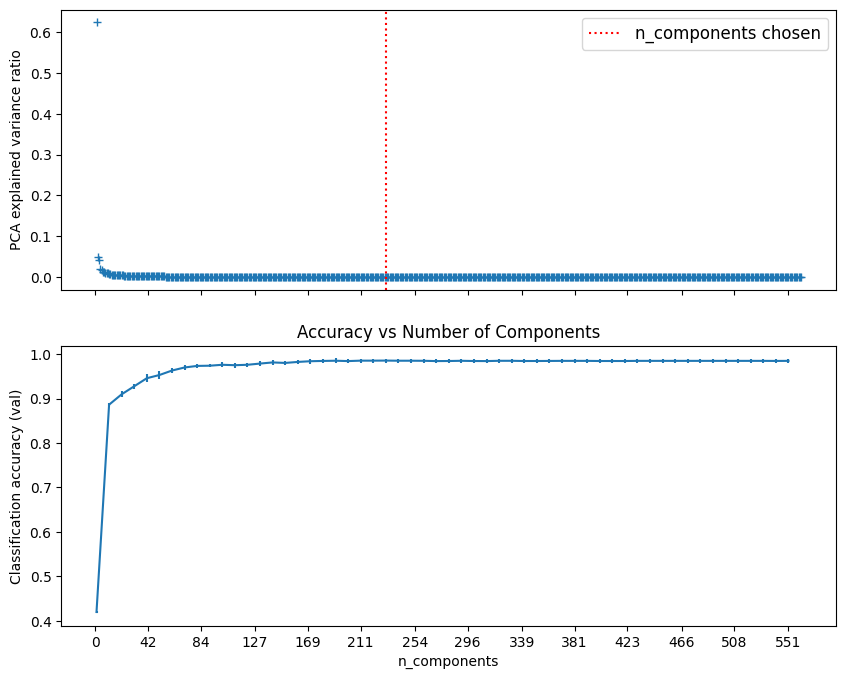

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

# gráfica del ratio de varianza explicada de PCA
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search_rbf.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
    color='red'
)
ax0.legend(prop=dict(size=12))

cv_results = pd.DataFrame(search_rbf.cv_results_)
components_col = "param_pca__n_components" # columna que contiene el número de componentes

best_clfs = ( # para cada número de componentes usado, seleccionar la fila con la mejor media de validación
    cv_results.loc[cv_results.groupby(components_col)["mean_test_score"].idxmax()]
    .sort_values(by=components_col)
)
# gráfica de accuracy vs número de componentes, con barras de error para la desviación estándar
ax1.errorbar(
    best_clfs[components_col],
    best_clfs["mean_test_score"],
    yerr=best_clfs["std_test_score"],
    #fmt='-o',
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")
ax1.set_title("Accuracy vs Number of Components")

ax0.xaxis.set_ticks(np.linspace(0, max(param_grid['pca__n_components']), 14).astype(int))
ax0.xaxis.set_ticklabels(np.linspace(0, max(param_grid['pca__n_components']), 14).astype(int))

plt.show()


Vemos que un par de componentes constituyen la gran mayoría de la varianza explicada del dataset, es decir, la cantidad de varianza relativa del dataset que explica cada componente.

Esto quiere decir que la eliminación de buena parte de los componentes con menor RVE (ratio de varianza explicada) no afectará en gran medida a la varianza total del dataset. Efectivamente, como vemos en el resultado de la segunda gráfica, la precisión se mantiene estable hasta aproximadamente las 150-200 características, donde mepieza a disminuír ligeramente.

Observamos que en la búsqueda, PCA obtiene como cantidad ideal de componentes 221.



### RFECV sobre el conjunto completo

Realizamos también una selección de atributos con *Recursive Feature Elimination*. El objetivo es comparar los resultados con PCA.

RFE utiliza un estimador para obtener una aproximación de la importancia de los atributos, y los va eliminando recuasivemente en cada llamada. Esta implementación concreta incluye validación cruzada, para la que se ha elegido un valor de 3 pliegues.

In [ ]:
min_features_to_select = 1  # Minimum number of features to consider
clf = LinearSVC()#SVC(C=10000, gamma=0.01, cache_size=2000)
cv = StratifiedKFold(3)

rfecv = RFECV(
    estimator=clf,
    step=15, # OJO ESTO ESTA CAMBIASDO
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

start = perf_counter()
rfecv.fit(X_train, y_train)
print_time(start)

Total training time:  2 min, 54.6 sec


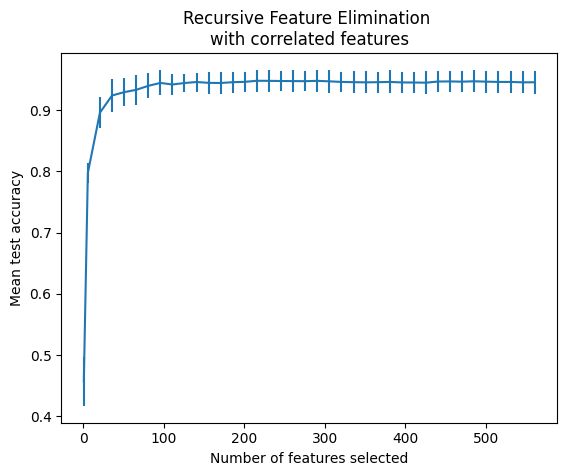

In [ ]:
# plot the results
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")

plt.savefig('/gdrive/MyDrive/UNIVERSIDADE/3º CURSO/APAU/figures/RFE-with-correlated-features.png',
            bbox_inches='tight')

plt.show()

El resultado y conclusiones que podemos sacar son muy similares al caso de PCA.

Cabe destacar que aunque esta ejecución particular de RFECV ha tomado poco tiempo, en general el coste a nivel de tiempo de este método es mayor: en nuestro ejemplo se ha usado un `step` de 15, es decir que en cada llamada recursiva se eliminan las 15 características menos importantes. Para obtener resultados óptimos esto no es lo ideal, y un `step` de 1 requiere una ejecución larga.

### RFECV sobre los componentes tras aplicar PCA

A continuación probamos la combinación de los dos métodos anteriores, y visualizamos la variación de precisión.

Sobre la instancia de PCA creada anteriormente se realizará una selección de atributos con RFECV.

In [ ]:
min_features_to_select = 1  # Minimum number of features to consider
clf = LinearSVC()

rfecv = RFECV(
    estimator=clf,
    step=15, # OJO ESTO ESTA CAMBIASDO
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

start = perf_counter()
rfecv.fit(X_pca, y_holdout_train) # usamos X_pca en lugar de X_holdout_train
print_time(start)

Total training time:  2 min, 33.8 sec


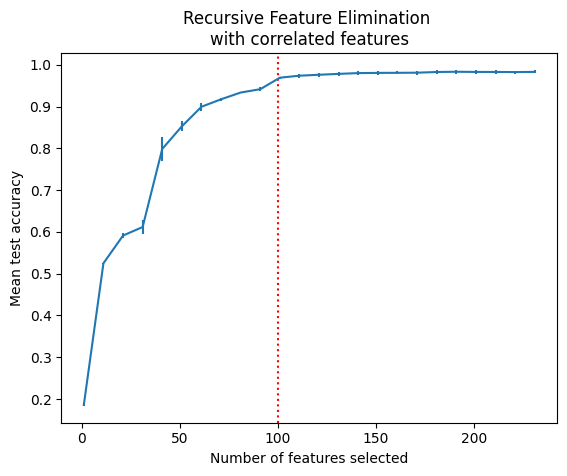

In [ ]:
# plot the results
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")


selected_dims = search_rbf.best_estimator_.named_steps["pca"].n_components # get final num of selected dimensions
idx = best_clfs.index[best_clfs[components_col]==selected_dims][0] #find index of the value in the dataframe

# slice the columns so they display the current number of used dimensions by rfecv after pca
x_sliced = best_clfs.loc[:idx, components_col]
y_sliced = cv_results.loc[:len(x_sliced)-1, "mean_test_score"]
yerr_sliced = cv_results.loc[:len(x_sliced)-1, "std_test_score"]

plt.errorbar(
    x=x_sliced,
    y=y_sliced,#cv_results["mean_test_score"],
    yerr=yerr_sliced#cv_results["std_test_score"],
)
# put a vertical line in accuracy dropoff
plt.axvline(x=100, color='red', linestyle=':', label="n_components chosen")

plt.title("Recursive Feature Elimination \nwith correlated features")

plt.savefig('/gdrive/MyDrive/UNIVERSIDADE/3º CURSO/APAU/figures/RFE+PCA-with-correlated-features.png',
            bbox_inches='tight')

plt.show()

Vemos más de cerca cómo varía la reducción de dimensionalidad la precisión del modelo.

Tras experimentar con estos 2 métodos, llegué a la conclusión de que lo mejor es utilizar PCA dado que tiene un coste computacional muy reducido con respecto a RFECV .
Esta ventaja tiene su inconveniente: se pierde interpretabilidad al proyectar los atributos, y no se puede saber a ciencia cierta qué representan los nuevos atributos que crea PCA. A pesar de esto, este será el método de reducción elegido a lo largo del cuaderno.

# Enfoque con SVM's

Se llevaron a cabo primero las aproximaciones al problema utilizando Máquinas de Soporte Vectorial.

### Preprocesado
Se utilizó e conjunto de datos sin modificaciones más allá de las descritas en la sección de Preprocesamiento anterior.

No se requiere cambiar los datos a una distribución específica, ya que las SVM's no realizan suposiciones de la distribución subyacente de los datos, como si lo hacen otros algoritmos como Naive Bayes, que requiere normalización por asumir una distribución normal.

[Lo que sí requieren las SVM's son datos escalados, usualmente en el intervalo $[-1,1]$ o $[0,1]$](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf). Ya que estos ya están escalados en este intervalo, como se vió anteriormente en el análisis del dataset, no se realizan pasos específicos de estandarización ni escalado de los datos.

### Hiperparámetros

Se realizó un procesamiento y optimización de hiperparámetros para cada uno de los kernels siguientes: `['rbf', 'linear', 'sigmoid']`. En cada uno de ellos se optimizan sus hiperparámetros específicos.

La decisón de realizar una búsqueda de hiperparámetros por kernel radica en que, aunque posible, especificar los hiperparámetros de todos los kernels en la misma búsqueda ampliaría el espacio de búsqueda enormemente, por lo que es mejor realizarlo de forma separada para ahorrar tiempo, y no introducir iteraciones en las que se modifican hiperparámetros que no afectan a un kernel determinado, como `degree` en el kernel lineal, por ejemplo.
  
Además, esto que permite una mejor comparación y análisis de los mismos ya que se puede realizar una evaluación individualizada de cada kernel.

### Validación

En la búsqueda se optó por un proceso de **validación cruzada estratificada con 4 pliegues**. Aunque el estándar suele ser de 5 pliegues, se optó por 4 ya que sigue siendo un número equilibrado en tamaño entre entrenamiento y validación, pero reduciendo ligeramente el coste computacional ya que en cada iteración de la búsqueda habrá que entrenar un modelo menos.

### Preprocesado

Los **hiperparámetros de la reducción de dimensionalidad utilizada se fijaron en el intervalo $[2,260]$** ya que se pretende mejorar el tiempo de entrenamiento y predicción, y un número reducido de dimensiones acelera estos procesos. Este es un número similar al previamente encontrado en el proceso de PCA, pero con algo de holgura para posibles mejoras ya que el valor se encontró para un modelo de SVM lineal y podría variar para otros kernels.


## Modelo base

Primero crearemos un modelo base que nos permita ver la performance del modelo sin ningún tipo de optimización de hiperparámetros ni preprocesamiento de datos.

De este modo, tendremos una base con la que comparar los resultados de los próximos modelos que usen el mismo algoritmo.

In [ ]:
svc = SVC(cache_size=2000) # un mayor tamaño de cache mejora la ejecucion en grandes cant. de datos
start = perf_counter()
svc.fit(X_holdout_train, y_holdout_train)
print_time(start) # usamos las funciones creadas previamente para comprobar el tiempo de entrenamiento

Total training time:  0 min, 3.5 sec


In [ ]:
analize_fitting_estimator(svc, X_holdout_train, y_holdout_train, X_val, y_val) # comparar resultados
model_evaluation(svc, X_train, y_train, X_test, y_test) # evaluar métricas del modelo

░░▒▒▓▓ Evaluating Overfitting on Validation and Training sets ▓▓▒▒░░
Model:  SVC(cache_size=2000)
accuracy_validation_set 0.9728014505893019
accuracy_training_set 0.9772763642182749
Accuracy difference between training and validation 0.00447491362897301

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.9481
F1-Score (weighted): 0.9480

Classification Report (simplified):
                    f1-score  support
STANDING              1.0000      537
SITTING               0.9142      491
LAYING                0.9265      532
WALKING               0.9613      496
WALKING_DOWNSTAIRS    0.9453      420
WALKING_UPSTAIRS      0.9367      471
accuracy              0.9481        0
macro avg             0.9473     2947
weighted avg          0.9480     2947



(0.9480827960637936, 0.9480067416691771)

Usamos la función `analize_fitting_estimator` para comprobar los resultados, y observamos que los valores por defecto de la SVC no producen overfitting.

También mostramos las métricas del modelo con la función de utilidad creada previamente.

### Observaciones

Los resultados de este modelo básico son destacables. En el paper original de los creadores del dataset se menciona que consiguieron un *accuracy del 96%*. Este modelo base, sin optimización, preprocesado, ni aparente overfitting, consigue una `accuracy` de 94% y un `f1-score` similar

Estos resultados son muy buenos para un modelo sin optimización de hiperparámetros. Si se consiguen tan buenos resultados sin hacer nada:
- ¿Se podrán optimizar otros aspectos como el tiempo de entrenamiento y predicción mediante la reducción de dimensionalidad?
- ¿Se podrán mantener los buenos resultados del modelo con esta optimización si se encuentran los hiperparámetros adecuados?

## Kernel RBF


### Hiperparámetros

Primero se realizó una **búsqueda del espacio de hiperparámetros por optimización bayesiana**.
Se eligió este método dada su capacidad para modelar la estructura del espacio de búsqueda y llegar antes a combinaciones adecuadas de hiperparámetros. Esto permite también relizar un análisis de la estructura del espacio de hiperparámetros a través de gráficas. También favorece su uso la implementación sencilla y adaptada a la API de *Scikit Learn* que ofrece la librería `scikit-optimize` a través de `BayesSearchCV`.
Las alternativas `RandomizedSearchCV` y `GridSearchCV` se descartaron ya que **presentan los siguientes inconvenientes**:

- El **coste computacional** de examinar el espacio completo que presenta grid search, o búsqueda exhaustiva, lo hace inviable, y este método pierde su capacidad de encontrar valores óptimos en espacios continuos.

- La búsqueda aleatoria es una opción que escala bien en general, y en promedio a partir de un número determinado de iteraciones encuentra valores adecuados para los hiperparámetros. A pesar de esto en espacios complejos, **el número de iteraciones requeridas puede ser grande**, por no mencionar que la gran ventaja de esta búsqueda es la paralelización, que no se puede aprovechar en el entorno utilizado (Google Colab solo permite el uso de 2 cores en la versión gratuíta.)

**Los hiperparámetros `gamma` y `C` de la SVM se crearon con una distribución logarítmica**, ya que [como se menciona en la documentación](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#train-classifiers) es recomendable hacer una búsqueda en un espacio logarítmico para tener un tuning mas fino en las partes del espacio donde se suelen concentrar los mejores hiperparámetros:

> *In practice, a logarithmic grid from $10^{-3}$ to $10^{3}$
is usually sufficient. If the best parameters lie on the boundaries of the grid, it can be extended in that direction in a subsequent search.*

### Preprocesado

Se eligió la **reducción por Análisis de Componentes Principales (PCA)** por su velocidad para realizar reducción de dimensionalidad sobre un gran número de dimensiones, como se ha mencionado en apartados anteriores.

### Otras aclaraciones

> Se siguió un proceso similar con ligeras variraciones para los siguientes kernels y algoritmos. Las expicaciones siguientes serán más breves ya que parte de la metodología no habrá cambiado, pero se explicarán los cambios que se hayan realizado.

> A la hora de realizar el entrenamiento de los modelos, se ha utilizado un enfoque que basado en pipelines.
Estas son más mantenibles y permiten cambiar transformadores y estimadores, manteniendo el código limpio y organizado y el preprocesamiento y entrenamiento bien definidos.
Este primer modelo tiene muchos comentarios ya que el funcionamiento de las pipelines es específico, con especificación de parámetros a través de formateo de strings y otras características especiales.

In [ ]:
# ESTOS SERÁN EL NUMERO DE FOLDS Y DE ITERACIONES EXCEPTO QUE SE DECLAREN DE NUEVO
CV_FOLDS = 4
NUM_ITER = 30
kfold = StratifiedKFold(n_splits=CV_FOLDS)# shuffle=False so the splits will be the same across calls.

In [ ]:
pipeline = Pipeline([   # definimos el Pipeline con un paso de reduccion
    ('dim_reduction', PCA()),
    ('svm', SVC(cache_size=2000))
])

# definimos el espacio de hiperparámetros
# "svm__" referencia el paso 'svm' de la pipeline
# estos nombres de la forma "x__y" se leen como "el parámetro *y* del elemento *x* en la pipeline"
param_grid = {
    'dim_reduction__n_components': Integer(2,260), # buscamos reducir la dimensionalidad
    'svm__gamma': Real(1e-3, 1e3, prior='log-uniform'),
    'svm__C': Real(1e-3, 1e3, prior='log-uniform'),
    'svm__kernel': ['rbf']
}
search_space_size(param_grid)

Size of hyperparameter space: 257999484 possible combinations.


In [ ]:
# configuramos la búsqueda de hiperparámetros. Se le puede pasar la pipeline
# y incluír el grid, y gracias a la especificación de "__" especificar los hiperparámetros
search_rbf = BayesSearchCV(
    pipeline,
    param_grid,
    n_iter=NUM_ITER,
    cv=kfold,  # se realiza un proceso de validación cruzada estratificada
    random_state=STATE,
    n_jobs=-1,
    return_train_score=True # devolvemos score de entrenamiento en folds de cv  para comprobar fitting
)

# entrenamos todo el pipeline (incluye escalado y búsqueda de hiperparámetros)
start = perf_counter()
search_rbf.fit(X_train, y_train)
print_time(start)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Total training time:  16 min, 17.7 sec


In [ ]:
# obtenemos los mejores hiperparámetros, también se pueden observar en la tabla
best_score_ = search_rbf.best_score_
print('Best score:', best_score_)

# Evaluamos el pipeline directamente sobre el conjunto de prueba
# la pipeline asegura que las transformaciones aplicadas al entrenamiento
# se replican exactamente en el test al llamar a pipeline.predict(X_test) (llamado dentro de la propia pipeline)
model_evaluation(search_rbf.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_rbf.cv_results_, top=3) # comprobar overfitting
cv

Best score: 0.9420565832426551
░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.9630
F1-Score (weighted): 0.9629

Classification Report (simplified):
                    f1-score  support
STANDING              1.0000      537
SITTING               0.9374      491
LAYING                0.9482      532
WALKING               0.9683      496
WALKING_DOWNSTAIRS    0.9684      420
WALKING_UPSTAIRS      0.9534      471
accuracy              0.9630        0
macro avg             0.9626     2947
weighted avg          0.9629     2947



mean_validation_score  mean_train_score  diff_train_validation  \
23                 0.9421               1.0                 0.0579   
18                 0.9410               1.0                 0.0590   
16                 0.9410               1.0                 0.0590   

    rank_validation_score  n_components       C     gamma kernel  
23                      1           233  1000.0  0.006235    rbf  
18                      2           260  1000.0  0.010741    rbf  
16                      2           260  1000.0  0.004191    rbf

### Observaciones

- A partir de la tabla de validación cruzada podemos observar que no se procude overfitting, ya que la diferencia de accuracy media entre validación y entrenamiento es baja.
- El modelo obtiene un resultado notable sobre el conjunto de test, y llega a la accuracy obtenida el [paper original](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf) de los creadores del dataset:

  > *The classification results using the multiclass SVM (MC-SVM) [...] show an overall accuracy of 96% for the test data composed
  of 2947 patterns.*

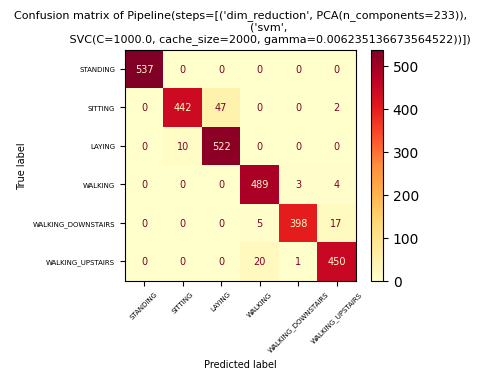

In [ ]:
show_confusion_matrix(search_rbf.best_estimator_, X_train, y_train, X_test, y_test)

- Vemos que el modelo confunde las clases de movimiento como predecíamos en la visualización de datos.

- Curiosamente, el modelo confunde más `LAYING` con `SITTNG` que cualquier otra cosa.

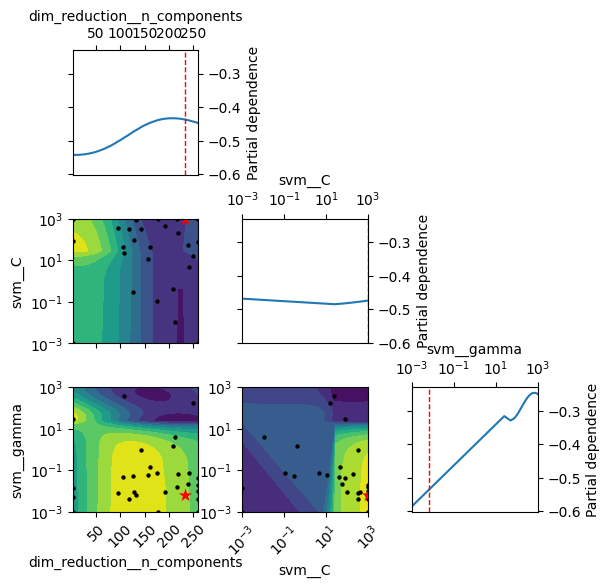

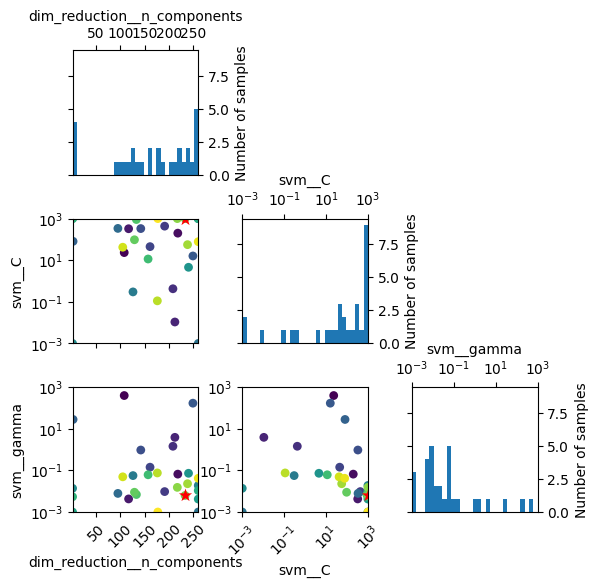

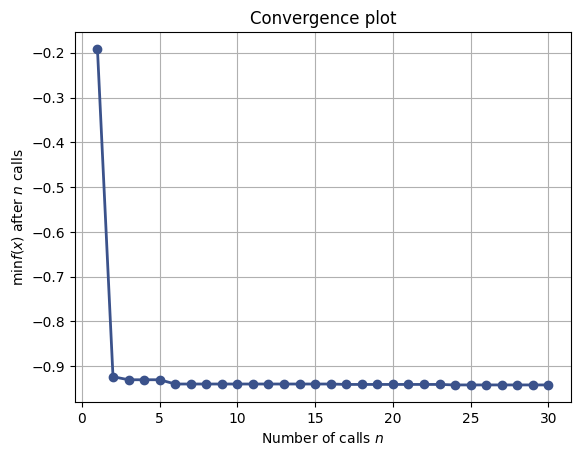

In [ ]:
plot_convergence_and_objective_function(search_rbf.optimizer_results_[0])

### Inciso

Estas gráficas muestran la evolución de la búsqueda por optimización bayesiana, y la evolución de la función objetivo con el número de iteraciones de la búsqueda.

Las gráficas de la diagonal principal representan el cambio de cada hiperparámetro y la dependencia parcial, esto es, como cambia cada hiperparámetro individual la función objetivo del modelo.

Las gráficas interiores muestran también el cambio de dependencia parcial de la función objetivo como un mapa de calor, y en los ejes se sitúan parejas de cada hiperparámetro.
Esto es, en este caso se muestra como el cambio de cada par de parámetros afecta a la función objetivo.

Es importante tener en cuenta que la función objetivo en esta optimización se minimiza, y es igual al opuesto del score que se está maximizando en la búsqueda. También hay que destacar que esta es la aproximación que realiza el proceso de optimización bayesiana del espacio de hiperparámetros, y que no se tiene que corresponder al 100% con el espacio real.

Las líneas y estrellas rojas representan el valor óptimo del hiperparámetro en ese punto de la optimización bayesiana, es decir, el valor que minimizó la función objetivo en el espacio explorado. Los puntos negros son las muestras evaluadas durante el proceso.

En el segundo gráfico, vemos también estos puntos y observamos un histograma en el que se muestra cuántas veces se han evaludado unos hiperparámetros concretos. Vemos que a medida que avanza la búsqueda se concentran las muestras en zonas más cercanas al óptimo.

Finalmente la tercera gráfica nos muestra la evolución de la función objetivo en cada iteración de la búsqueda bayesiana.


Conociendo esto, realizamos las siguientes observaciones:

- Observamos que el parámetro C del modelo podría no haber alcanzado su valor óptimo ya que está al borde del espacio de hiperparámetros. Esto puede querer decir que en valores mayores a $10³$ encontraremos un óptimo mejor.

- La función objetivo converge rápidamente, lo que sugiere que aunque cambiemos el espacio de búsqueda para $C$, probablemente las mejoras a esperar serán pequeñas.

- Observamos en los histogramas como el proceso de optimización distribuye las pruebas por el espacio basándose en las más prometedoras.

- No se selecciona el número máximo de componentes en PCA en el valor óptimo, sino 233, cercano al valor encontrado en el preprocesado.

## Kernel Polinomial

>  *\[...] the latter [polynomial kernel] is quite popular in natural language processing [...] The most common degree is d = 2 (quadratic), since larger degrees tend to overfit on NLP problems.*

El espacio transformado puede alcanzar dimensiones de hasta $ \binom{n + d - 1}{d} $ , donde $n=513$ y $d$ es el grado del polimomio. Esto se traduce en millones de características implícitas, lo que ralentiza drásticamente el entrenamiento.
[fuente](https://raw.githubusercontent.com/slds-lmu/lecture_sl/main/slides-pdf/slides-nonlinsvm-kernel-poly.pdf)

Por ahora este kernel es demasiado complejo en terminos de tiempo.
Si hay tiempo aproximarlo con esto:

[Scalable learning with polynomial kernel approximation](https://scikit-learn.org/1.5/auto_examples/kernel_approximation/plot_scalable_poly_kernels.html)

In [ ]:
pipeline = Pipeline([
    ('dim_reduction', PCA()),
    ('svm', SVC(cache_size=4000))
])
# estos nombres de la forma "x__y" se leen como "el parámetro *y* del elemento *x* en la pipeline"
param_grid = {
    'dim_reduction__n_components': list(range(2,10+1)), # buscamos reducir la dimensionalidad
    'svm__C': np.logspace(-2, 10, 20),
    'svm__degree': list(range(1,4)),
    #'svm__coef0' : (0, 0.001, 0.01, 0.1),#np.logspace(-2, 10, 35), # TODO quitado porque no se que hace y paraece que tarda muchisimo
    'svm__kernel': ['poly']
}
search_space_size(param_grid)

Size of hyperparameter space: 540 possible combinations.


In [ ]:
'''search_poly = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=2,
    cv=kfold,
    random_state=STATE,
    n_jobs=-1,
    return_train_score=True
)

start = perf_counter()
search_poly.fit(X_train, y_train)
print_time(start)'''

'search_poly = RandomizedSearchCV(\n    pipeline,\n    param_grid,\n    n_iter=2,\n    cv=kfold,\n    random_state=STATE,\n    n_jobs=-1,\n    return_train_score=True\n)\n\nstart = perf_counter()\nsearch_poly.fit(X_train, y_train)\nprint_time(start)'

In [ ]:
'''best_score_ = search_poly.best_score_
print('Best score:', best_score_)

model_evaluation(search_poly.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_poly.cv_results_, top=3) # comprobar overfitting
show_confusion_matrix(search_poly.best_estimator_, X_train, y_train, X_test, y_test)
cv'''

"best_score_ = search_poly.best_score_\nprint('Best score:', best_score_)\n\nmodel_evaluation(search_poly.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo\ncv, df = analize_fitting_crossval(search_poly.cv_results_, top=3) # comprobar overfitting\nshow_confusion_matrix(search_poly.best_estimator_, X_train, y_train, X_test, y_test)\ncv"

## Kernel Sigmoide



A continuación realizaremos la optimización del kernel sigmoide. El proceso llevado a cabo a nivel de conjunto de datos, preprocesado y validación del modelo es el mismo que para el anterior kernel, a excepción de los hiperparámetros, que cambian a los específicos requeridos por el kernel sigmoide.

https://en.wikipedia.org/wiki/Support_vector_machine#Properties

In [ ]:
pipeline = Pipeline([
    ('dim_reduction', PCA()),
    ('svm', SVC(cache_size=2000))
])
# estos nombres de la forma "x__y" se leen como "el parámetro *y* del elemento *x* en la pipeline"
param_grid = {
    'dim_reduction__n_components': Integer(2,260), # buscamos reducir la dimensionalidad
    'svm__C': Real(1e-3, 1e3, prior='log-uniform'),
    'svm__coef0' : Real(-5, 5),
    'svm__kernel': ['sigmoid']
}
search_space_size(param_grid)

Size of hyperparameter space: 2579997 possible combinations.


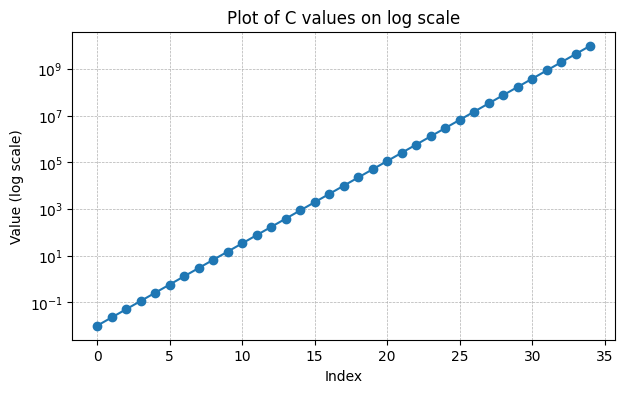

In [ ]:
values = np.logspace(-2, 10, 35)

plt.figure(figsize=(7, 4))
plt.plot(values, marker='o')
plt.yscale('log')  # y-axis to logarithmic scale
plt.title('Plot of C values on log scale')
plt.xlabel('Index')
plt.ylabel('Value (log scale)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


In [ ]:
search_sigmoid = BayesSearchCV(
    pipeline,
    param_grid,
    n_iter=NUM_ITER,
    cv=kfold,
    random_state=STATE,
    n_jobs=-1,
    return_train_score=True
)
start = perf_counter()
search_sigmoid.fit(X_train, y_train)
print_time(start)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Total training time:  12 min, 39.2 sec


In [ ]:
best_score_ = search_sigmoid.best_score_
print('Best score:', best_score_)

model_evaluation(search_sigmoid.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_sigmoid.cv_results_, top=3) # comprobar overfitting
cv

Best score: 0.9053318824809575
░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.9030
F1-Score (weighted): 0.8986

Classification Report (simplified):
                    f1-score  support
STANDING              1.0000      537
SITTING               0.9255      491
LAYING                0.9376      532
WALKING               0.8506      496
WALKING_DOWNSTAIRS    0.7221      420
WALKING_UPSTAIRS      0.9191      471
accuracy              0.9030        0
macro avg             0.8925     2947
weighted avg          0.8986     2947



mean_validation_score  mean_train_score  diff_train_validation  \
29                 0.9053            0.9570                 0.0517   
19                 0.8984            0.9499                 0.0515   
10                 0.8927            0.9438                 0.0511   

    rank_validation_score  n_components            C     coef0   kernel  
29                      1           260  1000.000000 -4.541722  sigmoid  
19                      2           260   446.979404 -4.568871  sigmoid  
10                      3           144   437.085902 -4.726768  sigmoid

### Observaciones

- De nuevo, a partir de la tabla de validación cruzada podemos observar que no se procude overfitting, ya que la diferencia de accuracy media entre validación y entrenamiento es baja.
- El modelo obtiene un resultado peor que el del modelo base. Esto puede ser una indicación de que no es un modelo adecuado para resolver este problema, o que los hiperparámetros aún no son los adecuados y se debe aumentar el número de iteraciones.

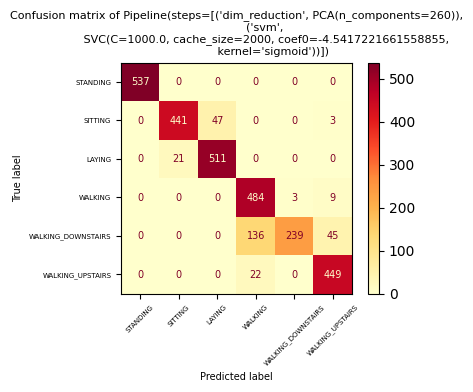

In [ ]:
show_confusion_matrix(search_sigmoid.best_estimator_, X_train, y_train, X_test, y_test)

- La matriz de confusión tiene una distribución similar a la anterior. Esto puede indicar que el kernel sigmoide y RBF tienen las mismas fortalezas y debilidades sobre este conjunto. Esto puede ser interesante de cara a realizar un ensemble de SVM's para descartar el kernel sigmoide en favor de un RBF con distintos hiperaprámetros por ejemplo.

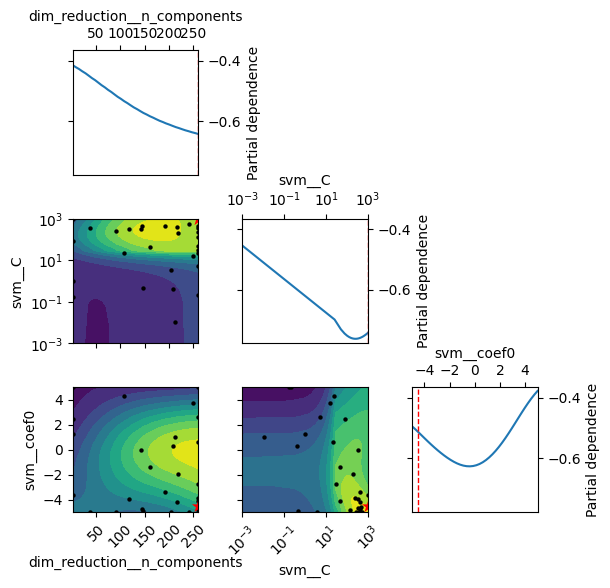

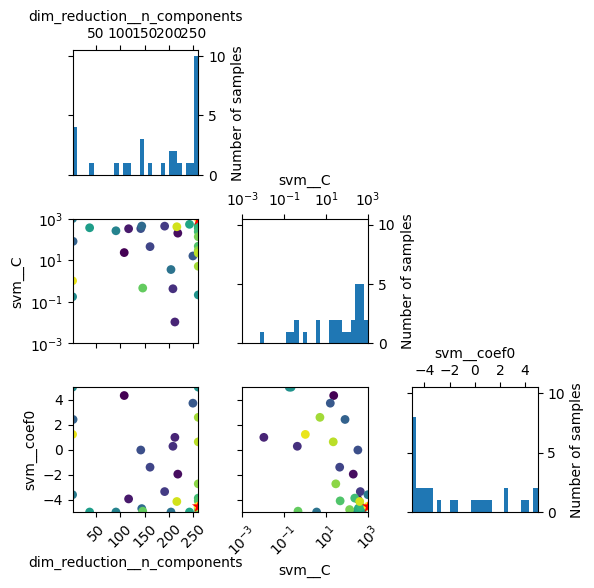

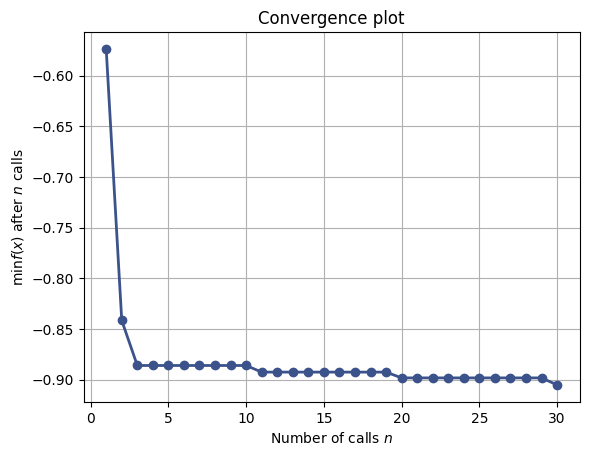

In [ ]:
plot_convergence_and_objective_function(search_sigmoid.optimizer_results_[0])

- Observamos que los parámetros $C$ y $n_components$ del modelo se encuentran en el borde del espacio de hiperparámetros. Es posible que requiera valores mayores de $C$, y esto podría indicar también que el modelo tiende a funcionar mejor con una mayor cantidad de dimensiones.

- La función objetivo converge rápido a valores adecuados.

- En los histogramas vemos que las muestras tomadas están más uniformemente distribuídas que en el kernel anterior. De nuevo, una posible señal de que haya que continuar la búsqueda.

## Kernel Lineal

In [ ]:
pipeline = Pipeline([
    ('dim_reduction', PCA()),
    ('svm', SVC())
])

param_grid = {
    'dim_reduction__n_components': Integer(2,260),
    'svm__C': Real(1e-3, 1e3, prior='log-uniform'),
    'svm__kernel': ['linear']
}
search_space_size(param_grid)

Size of hyperparameter space: 257999 possible combinations.


In [ ]:
search_linear = BayesSearchCV(
    pipeline,
    param_grid,
    n_iter=NUM_ITER,
    cv=kfold,
    random_state=STATE,
    n_jobs=-1,
    return_train_score=True
)
start = perf_counter()
search_linear.fit(X_train, y_train)
print_time(start)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Total training time:  6 min, 58.8 sec


In [ ]:
model_evaluation(search_linear.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_linear.cv_results_, top=3) # comprobar overfitting
cv

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.9623
F1-Score (weighted): 0.9622

Classification Report (simplified):
                    f1-score  support
STANDING              1.0000      537
SITTING               0.9200      491
LAYING                0.9341      532
WALKING               0.9733      496
WALKING_DOWNSTAIRS    0.9808      420
WALKING_UPSTAIRS      0.9667      471
accuracy              0.9623        0
macro avg             0.9625     2947
weighted avg          0.9622     2947



mean_validation_score  mean_train_score  diff_train_validation  \
12                 0.9399            0.9960                 0.0561   
4                  0.9393            0.9933                 0.0540   
21                 0.9392            0.9963                 0.0571   

    rank_validation_score  n_components         C  kernel  
12                      1           227  2.855331  linear  
4                       2           208  0.424791  linear  
21                      3           192  4.649320  linear

- De nuevo observamos que no hay overfitting en el modelo dado que `diff_train_validation` es bastante bajo.

- EL kernel lineal parece obtener unos resultados muy similares al RBF, pero con un tiempo de entrenamiento significativamente menor. Esto puede ser indicativo de un problema que, aunque no perfectamente, es bastante linealmente separable.

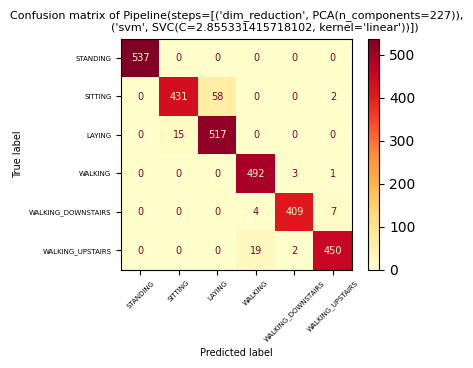

In [ ]:
show_confusion_matrix(search_linear.best_estimator_, X_train, y_train, X_test, y_test)

- Este kernel sigue teniendo problemas con las mismas clases que los anteriores.

- También realiza una mejor clasificación de las clases de movimiento, a cambio de más errores confundiendo `LAYING` con `SITTING`.

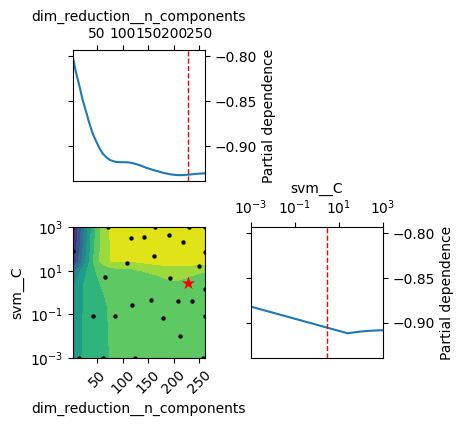

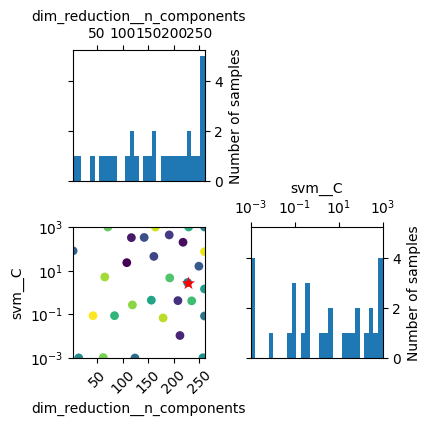

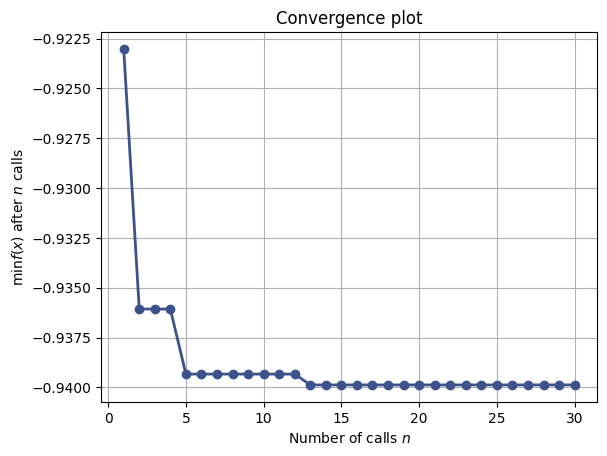

In [ ]:
plot_convergence_and_objective_function(search_linear.optimizer_results_[0])

- Como conclusiones de los hiperparámetros, vemos que en este caso la función alcanza un óptimo estable y no se encuentra en el borde del espacio. Esto junto con una convergencia temprana al óptimo nos lleva a pensar que estos eson los hiperparámetros adecuados para este kernel.

- También es interesante que este kernel, que también obtuvo buena puntuación, encuentra su óptimo con un número cercano al encontrado en el preprocesado de PCA, y no en el número máximo de componentes disponibles, que podría considerarse "más informativo".

https://scikit-learn.org/1.5/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py

https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-auto-examples-compose-plot-feature-union-py




# Enfoque con k-Nearest Neighbours

La idea general de este enfoque será la de utilizar los distintos algoritmos que se proprocionan para `KNeighborsClassifier` y averiguar cuales son los más rápidos sobre el conjuntos de datos sin sacrificar demasiada optimalidad.

### Hiperparámetros

De nuevo se realizaron una serie de **búsquedas en el espacio de hiperparámetros por optimización bayesiana**.
Como se menciona anteriormente, se han realizado las optimizaciones basadas en los distintos algoritmos. Se hará una para cada uno, y en cada una de ellas se optimizarán, además del parámetro $k$ (`n_neighbors`):
- Los pesos asignados a cada instancia, `uniform` o `distance`.
- El valor `p` para la distancia de Minkowsky, en un rango de $[1,5]$.

  $$d(x, y) = \left( \sum_{r=1}^n |x[r] - y[r]|^p \right)^{\frac{1}{p}}$$

  Los valores $1$ y $2$ equivalen a las distancias Manhattan y euclídea respectivamente. Valores superiores aumentan la importancia que se le da a las diferencias más grandes de $x[r]-y[r]$.

- `algorithm`: el algoritmo utilizado para la computación de los vecinos más cercanos.

  - `brute`: el algoritmo estándar, comprueba todos las instancias del dataset para ver cuáles son las más cercanas.

  - `kd-tree`: utilizando un árbol k-dimensional como estructura de datos auxiliar permite acelerar el algoritmo estándar en números bajos de dimensiones.

  - `ball-tree`: utilizando una estructura de árbol en la que las hojas son una serie de hiperesferas anidadas puede mejorar el rendimiento de `kd-tree` en números altos de dimensiones, a costa de un overhead en la creación de dicha estructura.

### Validación
De nuevo se realizó el mismo proceso de **validación cruzada estratificada con 4 pliegues**, exceptuando un caso concreto.


### Preprocesado

Los **hiperparámetros de la reducción de dimensionalidad utilizada variarán su intervalo para cada algoritmo,** ya que su funcionamiento óptimo varía en distintos rangos de dimensiones.

De nuevo, **no se requiere un preprocesado específico de escalado para kNN, ya que los datos iniciales ya están preprocesados** y escalados a un mismo rango entre $[-1,1]$.

Se **volvió a aplicar PCA** por los motivos descritos en la sección de reducción de dimensionalidad.

## Modelo Base

De nuevo creamos un modelo base sin optimización de hiperparámetros ni preprocesamiento para comparar los resultados de los próximos modelos basados en kNN.

Cabe destacar que sin especificación de hiperaprámetros, `KneighborsClassifier` toma por defecto los siguientes:

- `n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'`

Para tener una idea de como se comporta el algoritmo 'estándar' de kNN, se especificará el parámetro `algorithm='brute'` ya que es el más básico de los disponibles, y en caso de no especificarlo, el algoritmo se elige automáticamente en función de los datos que se le pasen.

In [ ]:
knn = KNeighborsClassifier(algorithm='brute')
start = perf_counter()
knn.fit(X_holdout_train, y_holdout_train)
print_time(start)

Total training time:  0 min, 0.1 sec


In [ ]:
analize_fitting_estimator(knn, X_holdout_train, y_holdout_train, X_val, y_val) # comparar resultados
acc_knn_base, f1_knn_base = model_evaluation(knn, X_train, y_train, X_test, y_test) # evaluar métricas del modelo

░░▒▒▓▓ Evaluating Overfitting on Validation and Training sets ▓▓▒▒░░
Model:  KNeighborsClassifier(algorithm='brute')
accuracy_validation_set 0.9673617407071623
accuracy_training_set 0.9822371579452712
Accuracy difference between training and validation 0.014875417238108923

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8992
F1-Score (weighted): 0.8983

Classification Report (simplified):
                    f1-score  support
STANDING              0.9963      537
SITTING               0.8447      491
LAYING                0.8767      532
WALKING               0.9101      496
WALKING_DOWNSTAIRS    0.8583      420
WALKING_UPSTAIRS      0.8903      471
accuracy              0.8992        0
macro avg             0.8961     2947
weighted avg          0.8983     2947



### Observaciones

- Este modelo ejecutado sobre el conjunto de entrenamiento completo muestra un rendimiento algo más pobre que los anteriores modelos basados en SVM's.

- No se observa overfitting con los hiperparámetros por defecto.

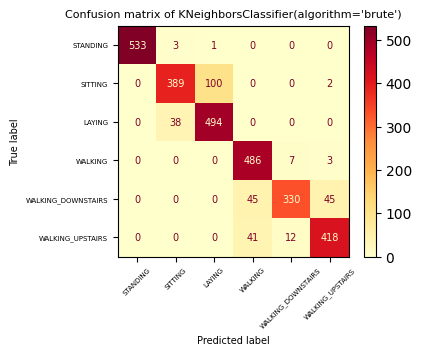

In [ ]:
show_confusion_matrix(knn, X_train, y_train, X_test, y_test)

## Mejores hiperparámetros

A continuación definiremos una búsqueda para un modelo kNN cuyo objetivo será, al menos, igualar al modelo base, pero disminuyendo el número de dimensiones para optimizar el timepo de ejecución.

El cálculo de distancias en alta dimensionalidad tiene un coste computacional elevado, y por ello buscamos reducirlo.

Por tanto, se buscarán los mejores hiperparámetros para el modelo con todas las dimensiones determinadas como relevantes por el PCA inicial (251). Aunque el valor inicial se encontró realizando PCA con una LinearSVC, puede ser un buen valor general para los demás algoritmos.


In [ ]:
pipeline = Pipeline([
    ('dim_reduction', PCA(n_components=251)), # set the components to what we found at preprocessing
    ('knn', KNeighborsClassifier())
])

param_grid = {

    'knn__n_neighbors': Integer(1,50),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': Integer(1, 10),
    'knn__algorithm': ['kd_tree'], # para que vaya más rápido
}
search_space_size(param_grid)

Size of hyperparameter space: 882 possible combinations.


Realizamos una búsqueda más pequeña que las anteriores, ya que tras varias pruebas se ha observado que puede llevar bastante tiempo.

Utilizaremos una **búsqueda por optimización bayesiana con 10 iteraciones, y una validación cruzada de 3 pliegues.**

In [ ]:
search_knn = BayesSearchCV(
  pipeline,
  param_grid,
  n_iter=10,
  cv=3,
  random_state=STATE,
  n_jobs=-1,
  return_train_score=True
)

start = perf_counter()
search_knn.fit(X_train, y_train)
print_time(start)

Total training time:  20 min, 36.2 sec


In [ ]:
model_evaluation(search_knn.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_knn.cv_results_, top=3) # comprobar overfitting
cv

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8951
F1-Score (weighted): 0.8937

Classification Report (simplified):
                    f1-score  support
STANDING              0.9981      537
SITTING               0.8254      491
LAYING                0.8664      532
WALKING               0.9016      496
WALKING_DOWNSTAIRS    0.8506      420
WALKING_UPSTAIRS      0.9072      471
accuracy              0.8951        0
macro avg             0.8915     2947
weighted avg          0.8937     2947



mean_validation_score  mean_train_score  diff_train_validation  \
5                 0.8889            0.9481                 0.0592   
2                 0.8887            0.9492                 0.0605   
1                 0.8770            1.0000                 0.1230   

   rank_validation_score algorithm  n_neighbors  p   weights  
5                      1   kd_tree           47  2   uniform  
2                      2   kd_tree           46  2   uniform  
1                      3   kd_tree           44  4  distance

### Observaciones

- Vemos que, a pesar del número bajo de iteraciones y haber reducido el número de dimensiones, el modelo consigue llegar a una precisión de 0.89, igual a la del modelo base hasta 2 cifras decimales.

- Comprobamos que no se produce overfitting.

-  El entrenamiento del modelo es muy costoso, con un total de 20 minutos para 10 iteraciones con 3 pliegues, es decir, 30 entrenamientos totales.

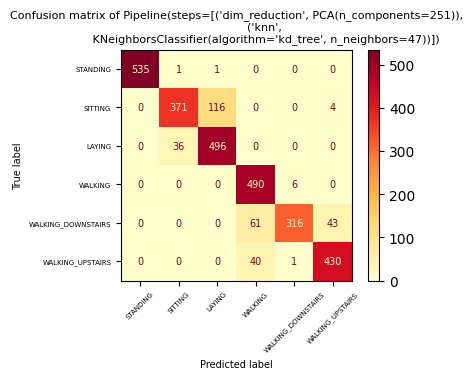

In [ ]:
show_confusion_matrix(search_knn.best_estimator_, X_train, y_train, X_test, y_test)

- El modelo reproduce los patrones habituales de errores en la clasificación.

In [ ]:
pipe = Pipeline([
    ('dim_reduction', PCA(n_components=251)),
    ('knn', KNeighborsClassifier())
])

results_per_algo = dict()
algos = ['kd_tree', 'ball_tree', 'brute']
leaf_sizes = range(30, 1530+1, 100)
results_per_algo['n_leaves'] = list(leaf_sizes)
reps_per_algo = 3 # to account for possible variations

for algo in algos: # for each algorithm...

  training_times = []
  pipe.set_params(**search_knn.best_params_) # reset params
  pipe.set_params(knn__algorithm=algo) # and use the proper algo
  pipe.fit(X_train, y_train)

  for leaf_size in leaf_sizes: # and for each specified leaf size...
    pipe.set_params(knn__leaf_size=leaf_size)
    avg_time = 0

    for _ in range(reps_per_algo): # do `reps_per_algo` measurings of time ...
      start = perf_counter()
      pipe.predict(X_test)
      avg_time += perf_counter() - start

    avg_time /= reps_per_algo # and average them...
    training_times.append(avg_time) # and then add them to the training time list...

  print(training_times)
  results_per_algo[algo] = training_times # wich will be added to the algo's register

[6.13316173433365, 5.819271218332385, 5.916412579999208, 7.058295963666751, 6.536354475002251, 8.574224199001037, 6.094312234332999, 5.729578296998322, 6.670640920330091, 7.388121148331265, 6.5295281670017475, 8.33049829066537, 5.757999428002222, 5.867946044665587, 5.973983419333915, 5.991415971332269]
[8.975801912665096, 9.031446265000946, 10.851010894332527, 12.09239865133471, 12.306610360666431, 10.43640137733261, 10.891008731998832, 9.9748971579999, 9.205822850332575, 9.029342316333592, 9.020661506001488, 8.778165639329623, 9.56570083899957, 9.00611487699886, 9.167596641668448, 8.947764957995483]
[0.9133195213313835, 0.5594004459975016, 0.5608464679996056, 0.5549219679984768, 0.5664363799999895, 0.5609999393345788, 0.6087498496684324, 0.9446313766675303, 0.862698568002088, 0.5652209183341862, 0.5730342350022207, 0.5662020253342538, 0.5580272126680939, 0.5607260089988509, 0.6633592310002617, 0.9397371426651565]


In [ ]:
df = pd.DataFrame(results_per_algo)
df.head()

n_leaves   kd_tree  ball_tree     brute
0        30  6.133162   8.975802  0.913320
1       130  5.819271   9.031446  0.559400
2       230  5.916413  10.851011  0.560846
3       330  7.058296  12.092399  0.554922
4       430  6.536354  12.306610  0.566436

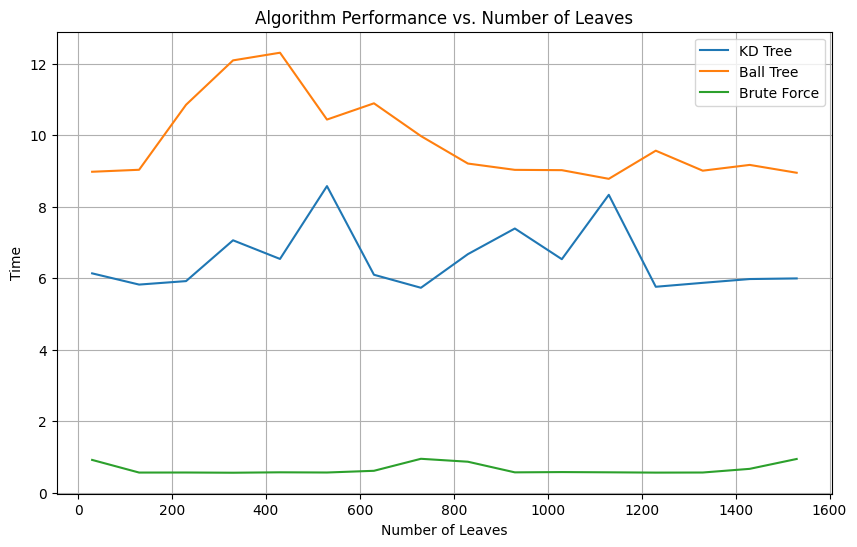

In [ ]:
# Create the line plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot each algorithm's performance
plt.plot(df['n_leaves'], df['kd_tree'], label='KD Tree')
plt.plot(df['n_leaves'], df['ball_tree'], label='Ball Tree')
plt.plot(df['n_leaves'], df['brute'], label='Brute Force')

# Customize the plot
plt.xlabel('Number of Leaves')
plt.ylabel('Time')
plt.title('Algorithm Performance vs. Number of Leaves')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Algoritmo KD

A continuación intentaremos llevar mas allá la optimización a nivel de tiempo de entrenamiento.

Primero optimizaremos el algoritmo KD.

Este algoritmo crea una estructura de datos de árbol (del mismo nombre), que divide las k dimensiones del conjunto de datos (distinto de k referido a número de vecinos) de forma recursiva. El hecho de no tener que comparar con todas las muestras del conjunto de entrenamiento le permite ejecutarse en un menor tiempo.

En la [documentación encontramos](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms) que la dimensionalidad óptima de trabajo de este algoritmo tiene un límite:

> *\[...] Though the KD tree approach is very fast for low-dimensional ($D<20$) neighbors searches, it becomes inefficient as
grows very large: this is one manifestation of the so-called “curse of dimensionality”.*

Por tanto utilizaremos un hiperparámetro de `n_components` de 20 para la reducción de dimensionalidad con PCA. Los demás hiperparámetros se volverán a ajustar también ya que no podemos asegurar que no haya una dependencia condicional entre estos y el número de dimensiones utilizadas.

También se modifica el parámetro `leaf_size` a 100 para mejorar el tiempo de creación del árbol, ya que esto provocará que cree un árbol menos profundo.

In [ ]:
pipeline = Pipeline([
  ('dim_reduction', PCA()),
  ('knn', KNeighborsClassifier(leaf_size=100))
])

param_grid = {
  'dim_reduction__n_components': Integer(2,20), # as suggested in documentation
  'knn__n_neighbors': Integer(1,50),
  'knn__weights': ['uniform', 'distance'],
  'knn__p': Integer(1, 5),
  'knn__algorithm': ['kd_tree'],
}
search_space_size(param_grid)

Size of hyperparameter space: 7056 possible combinations.


De nuevo volveremos al número inicial de iteraciones (30) y pliegues (4) que determinamos inicialmente.

In [ ]:
search_knn_kd = BayesSearchCV(
  pipeline,
  param_grid,
  n_iter=NUM_ITER,
  cv=kfold,
  random_state=STATE,
  n_jobs=-1,
  return_train_score=True
)

start = perf_counter()
search_knn_kd.fit(X_train, y_train)
print_time(start)

Total training time:  6 min, 50.8 sec


In [ ]:
model_evaluation(search_knn_kd.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_knn_kd.cv_results_, top=3) # comprobar overfitting
cv

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8683
F1-Score (weighted): 0.8673

Classification Report (simplified):
                    f1-score  support
STANDING              0.9820      537
SITTING               0.7824      491
LAYING                0.8300      532
WALKING               0.8944      496
WALKING_DOWNSTAIRS    0.8140      420
WALKING_UPSTAIRS      0.8859      471
accuracy              0.8683        0
macro avg             0.8648     2947
weighted avg          0.8673     2947



mean_validation_score  mean_train_score  diff_train_validation  \
27                 0.8611            0.9407                 0.0795   
20                 0.8606            0.9290                 0.0685   
22                 0.8588            0.9315                 0.0727   

    rank_validation_score  n_components algorithm  n_neighbors  p  weights  
27                      1            20   kd_tree           18  2  uniform  
20                      2            20   kd_tree           41  1  uniform  
22                      3            20   kd_tree           37  1  uniform

- El tiempo de ejecución se ha reducido significativamente en comparación con la búsqueda anterior, que también empleaba `kd-tree`. A costa de ello, las métricas se han reducido de $0.89$ a $0.86$, situando a este modelo por debajo del modelo base.

- LinearSVC proporciona un mucho mejor ratio de optimalidad por tiempo de entrenamiento.

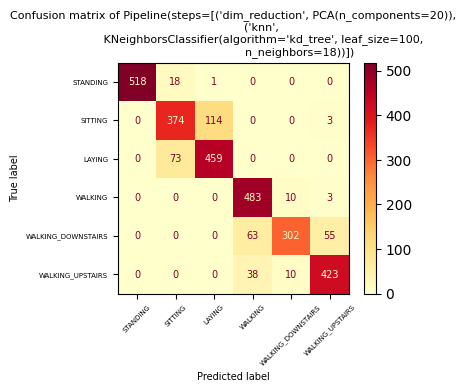

In [ ]:
show_confusion_matrix(search_knn_kd.best_estimator_, X_train, y_train, X_test, y_test)

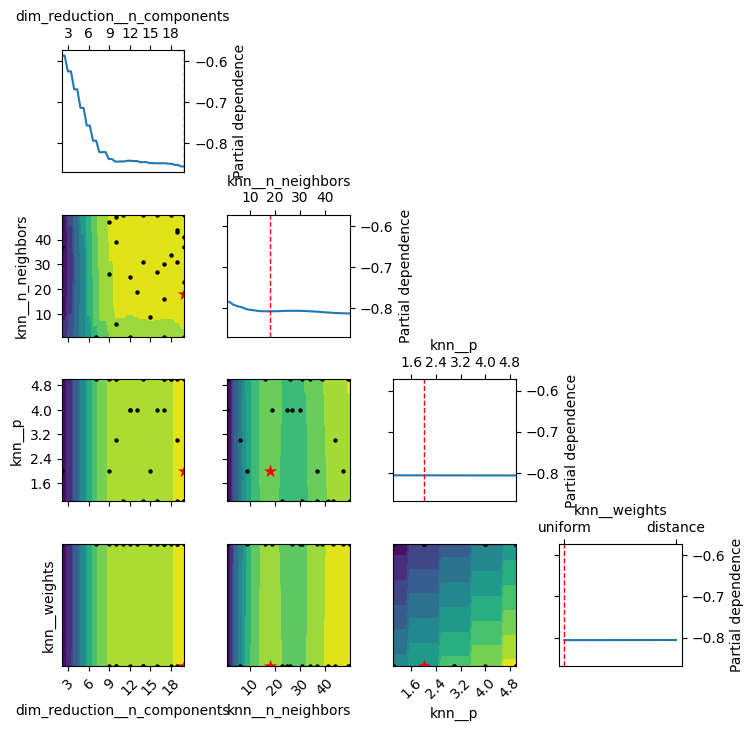

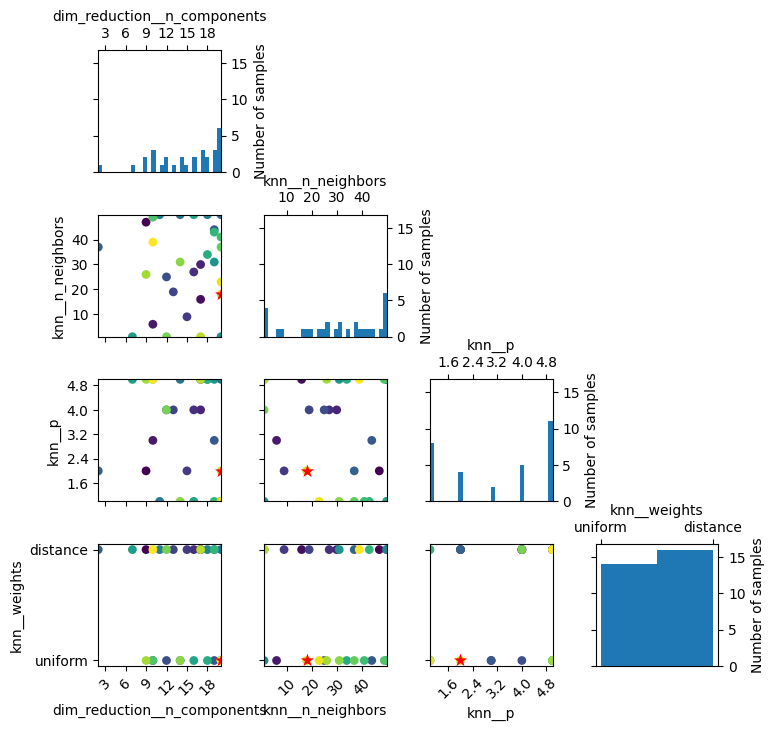

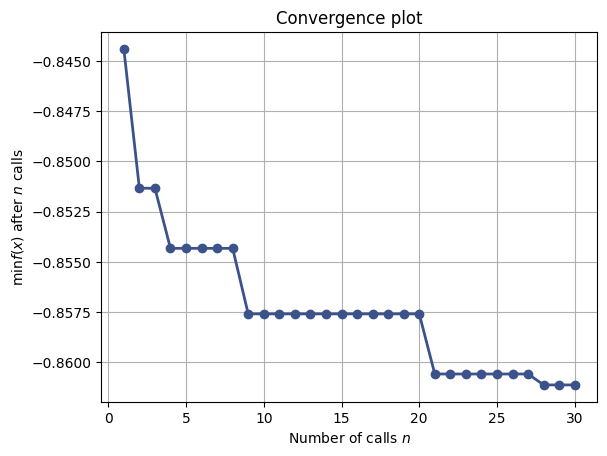

In [ ]:
plot_convergence_and_objective_function(search_knn_kd.optimizer_results_[0])

- En el mapa de calor generado podemos observar que los hiperaprámetros `p` y `weights` no parecen aportar mucho a la mejora de la función objetivo, ya que su dependencia parcial es constante y por tanto no importa demasiado su valor. Esto se refleja también en las distribuciones de las muestras tomadas para estos hiperparámetros, que son algo uniformes.

- La función converge de forma escalonada, pero parece llegar a un punto estable.

## Algoritmo Ball Tree

De nuevo buscamos optimizar el tiempo de entranamiento, esta vez utilizando el algoritmo Ball Tree.

La documentación lo describe como una versión mejor adaptada a funcionar con gran cantidad de dimensiones:

> *\[...] Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly structured data, even in very high dimensions.*

Por ello utilizaremos un número algo mayor de dimensiones, pero no demasiado, ya que este algoritmo puede tener un coste alto dada la creación de la estructura de datos. Probaremos con 50 componentes.

In [ ]:
pipeline = Pipeline([
  ('dim_reduction', PCA()),
  ('knn', KNeighborsClassifier(leaf_size=100))
])

param_grid = {
  'dim_reduction__n_components': Integer(2,50),#300),
  'knn__n_neighbors': Integer(1,50),
  'knn__weights': ['uniform', 'distance'],
  'knn__p': Integer(1, 5),
  'knn__algorithm': ['ball_tree'],
}
search_space_size(param_grid)

Size of hyperparameter space: 18816 possible combinations.


In [ ]:
search_knn_ball = BayesSearchCV(
  pipeline,
  param_grid,
  n_iter=NUM_ITER,
  cv=kfold,
  random_state=STATE,
  n_jobs=-1,
  return_train_score=True
)

start = perf_counter()
search_knn_ball.fit(X_train, y_train)
print_time(start)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Total training time:  19 min, 6.7 sec


In [ ]:
model_evaluation(search_knn_ball.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_knn_ball.cv_results_, top=3) # comprobar overfitting
cv

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8887
F1-Score (weighted): 0.8879

Classification Report (simplified):
                    f1-score  support
STANDING              0.9830      537
SITTING               0.8177      491
LAYING                0.8569      532
WALKING               0.9094      496
WALKING_DOWNSTAIRS    0.8553      420
WALKING_UPSTAIRS      0.8943      471
accuracy              0.8887        0
macro avg             0.8861     2947
weighted avg          0.8879     2947



mean_validation_score  mean_train_score  diff_train_validation  \
28                 0.8764            0.9527                 0.0764   
10                 0.8755            1.0000                 0.1245   
22                 0.8745            0.9428                 0.0684   

    rank_validation_score  n_components  algorithm  n_neighbors  p   weights  
28                      1            50  ball_tree           32  1   uniform  
10                      2            50  ball_tree           50  1  distance  
22                      3            43  ball_tree           50  1   uniform

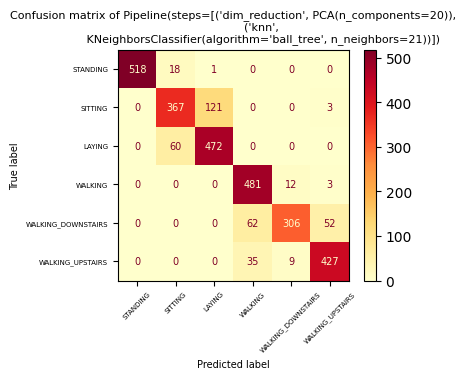

In [ ]:
show_confusion_matrix(search_knn_ball.best_estimator_, X_train, y_train, X_test, y_test)

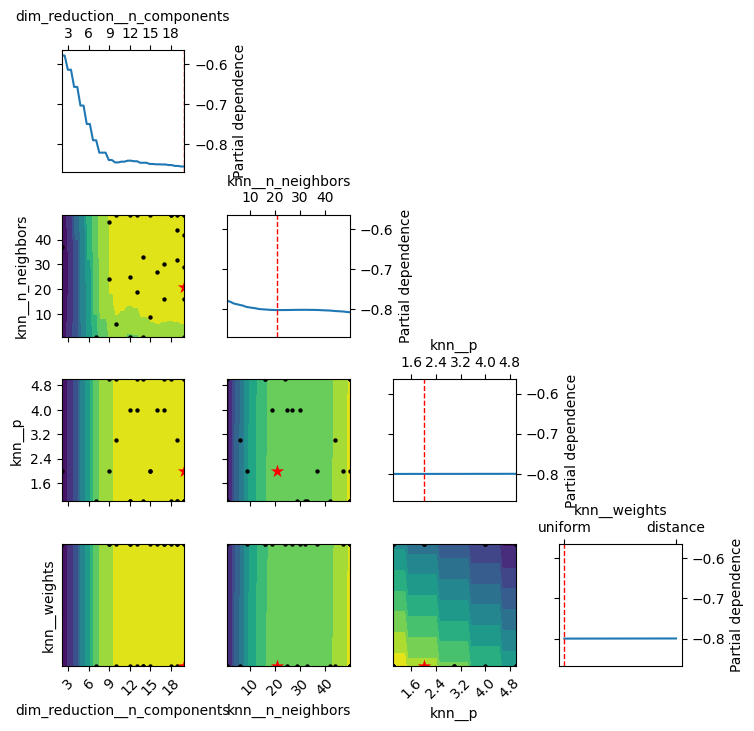

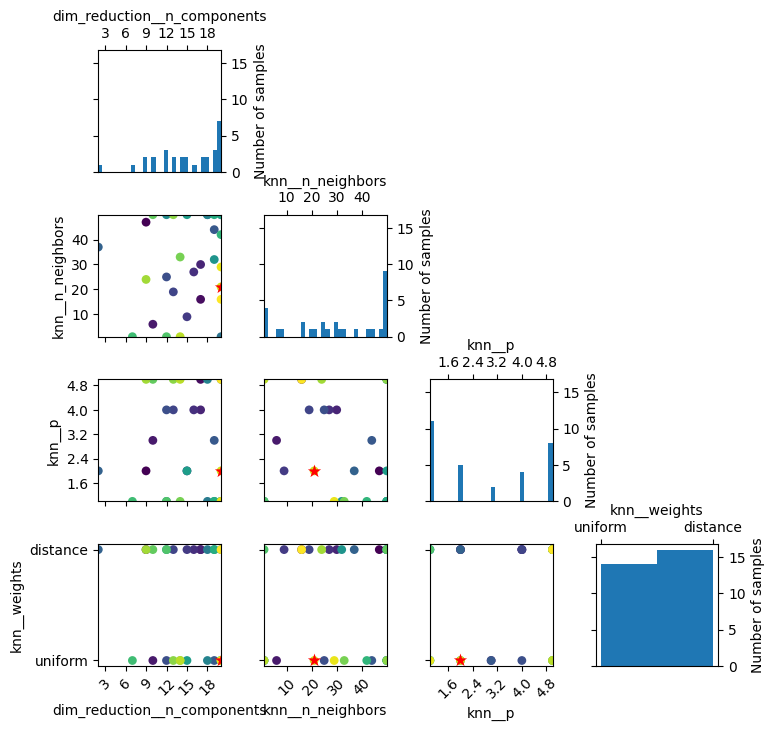

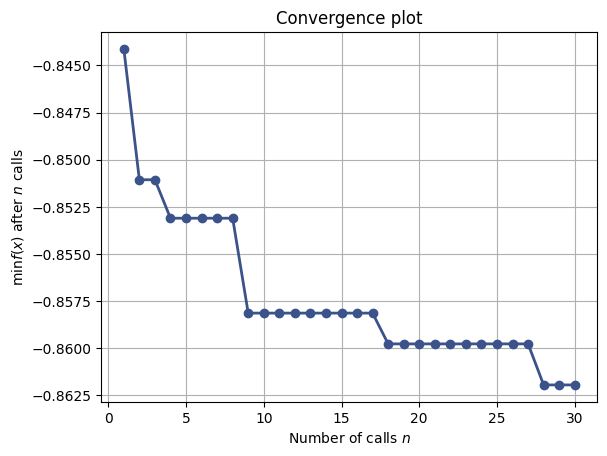

In [ ]:
plot_convergence_and_objective_function(search_knn_ball.optimizer_results_[0])

## Conclusiones

[tree knn benchmarks](https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/#Scaling-with-Leaf-Size)

# Enfoque con Árboles de decision

Finalmente se abordará la solución al problema utilizando árboles de decisión.

En este enfoque se experimentará con la capacidad de pre-pruning de los árboles, además de su funcionamiento con distintas cantidades de dimensiones.

### Hiperparámetros

De nuevo se realizó una **búsqueda del espacio de hiperparámetros por optimización bayesiana**.


- `tree__max_depth`: Controla la profundidad máxima del árbol. Limitar la profundidad puede prevenir el sobreajuste, mientras que permitir más niveles aumenta la complejidad y el riesgo de sobreajuste.

- `tree__max_leaf_nodes`: Establece el número máximo de nodos hoja que puede tener el árbol. Restringir este valor simplifica el árbol y ayuda a evitar el sobreajuste, pero valores demasiado bajos pueden provocar subajuste.

- `tree__min_samples_split`: Define el número mínimo de muestras necesario para dividir un nodo. Valores bajos permiten nodos con pocas instancias (posible sobreajuste), mientras que valores altos simplifican el árbol y reducen el riesgo de sobreajuste.

- `tree__min_samples_leaf`: Especifica el número mínimo de muestras que debe haber en cada nodo hoja. Un valor más alto asegura hojas más robustas y puede reducir la varianza del modelo, mientras que valores bajos aumentan el riesgo de sobreajuste.

Se ignoró el hiperparámetro de selección de división ya que como se puede observar en el artículo [Theoretical comparison between the Gini Index and
Information Gain criteria](https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf), no parece marcar una gran diferencia cuál elegir a la hora de mejorar la efectividad del modelo:

> *...no feature selection rule is consistently
superior to the others, and that no specific strategy for alternating different rules is significantly more effective.*

> *...the tree quality does not seem to depend on the specific criterion used.*

### Validación
De nuevo se realizó el mismo proceso de **validación cruzada estratificada con 4 pliegues**.

### Preprocesado
Los árboles de decisión son modelos robustos ante datos sin preprocesamiento, en distintos rangos, o incluso con valores faltantes. Por ello tampoco se requiere preprocesado extra.

Se **volvió a aplicar PCA** por los motivos descritos en la sección de reducción de dimensionalidad.


## Modelo base


In [ ]:
base = DecisionTreeClassifier()
start = perf_counter()
base.fit(X_holdout_train, y_holdout_train)
print_time(start)

Total training time:  0 min, 9.4 sec


In [ ]:
analize_fitting_estimator(base, X_holdout_train, y_holdout_train, X_val, y_val) # comparar resultados
model_evaluation(base, X_train, y_train, X_test, y_test) # evaluar métricas del modelo

░░▒▒▓▓ Evaluating Overfitting on Validation and Training sets ▓▓▒▒░░
Model:  DecisionTreeClassifier()
accuracy_validation_set 0.9356300997280145
accuracy_training_set 1.0
Accuracy difference between training and validation 0.06436990027198553

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8470
F1-Score (weighted): 0.8465

Classification Report (simplified):
                    f1-score  support
STANDING              1.0000      537
SITTING               0.8254      491
LAYING                0.8501      532
WALKING               0.8512      496
WALKING_DOWNSTAIRS    0.7834      420
WALKING_UPSTAIRS      0.7410      471
accuracy              0.8470        0
macro avg             0.8418     2947
weighted avg          0.8465     2947



(0.8469630132337971, 0.8465428321017149)

## Árbol sin reducción de dimensionalidad

Realizamos una ejecución con el árbol sin reducción de dimensionalidad pero con hiperparámetros de pre-pruning. Si estos parámetros bastan para auto-regular la complejidad del árbol, no habrá overfitting.

In [ ]:
maxdepth = base.tree_.max_depth
nleaves = base.tree_.n_leaves

In [ ]:
pipeline = Pipeline([
  # aqui quité la reduccion
  ('tree', DecisionTreeClassifier())
])

param_grid = {
  # parámetro de la reducción eliminado
  'tree__max_depth' : Integer(2,maxdepth),
  'tree__max_leaf_nodes' : Integer(2,nleaves),
  'tree__min_samples_split': Integer(2, 100),
  'tree__min_samples_leaf': Integer(2, 100),
}

search_space_size(param_grid)

Size of hyperparameter space: 27265756 possible combinations.


In [ ]:
search_tree = BayesSearchCV(
  pipeline,
  param_grid,
  n_iter=NUM_ITER,
  cv=kfold,
  random_state=STATE,
  n_jobs=-1,
  return_train_score=True
)
start = perf_counter()
search_tree.fit(X_train, y_train)
print_time(start)

Total training time:  6 min, 37.9 sec


In [ ]:
best_score_ = search_tree.best_score_
print('Best score:', best_score_)

model_evaluation(search_tree.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_tree.cv_results_, top=3) # comprobar overfitting
cv

Best score: 0.853917301414581
░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8554
F1-Score (weighted): 0.8540

Classification Report (simplified):
                    f1-score  support
STANDING              1.0000      537
SITTING               0.8135      491
LAYING                0.8485      532
WALKING               0.8851      496
WALKING_DOWNSTAIRS    0.7764      420
WALKING_UPSTAIRS      0.7727      471
accuracy              0.8554        0
macro avg             0.8494     2947
weighted avg          0.8540     2947



mean_validation_score  mean_train_score  diff_train_validation  \
16                 0.8539            0.9391                 0.0852   
18                 0.8535            0.9365                 0.0830   
4                  0.8535            0.9292                 0.0757   

    rank_validation_score  max_depth  max_leaf_nodes  min_samples_leaf  \
16                      1         16             129                40   
18                      2         15              50                45   
4                       3         16              75                54   

    min_samples_split  
16                 89  
18                 82  
4                  72

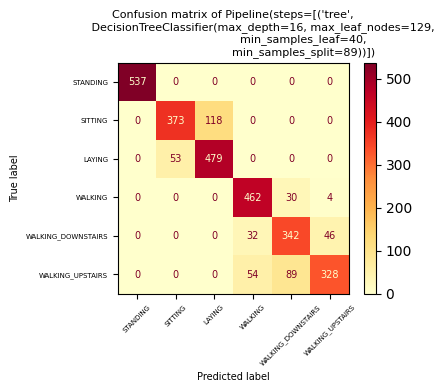

In [ ]:
show_confusion_matrix(search_tree.best_estimator_, X_train, y_train, X_test, y_test)

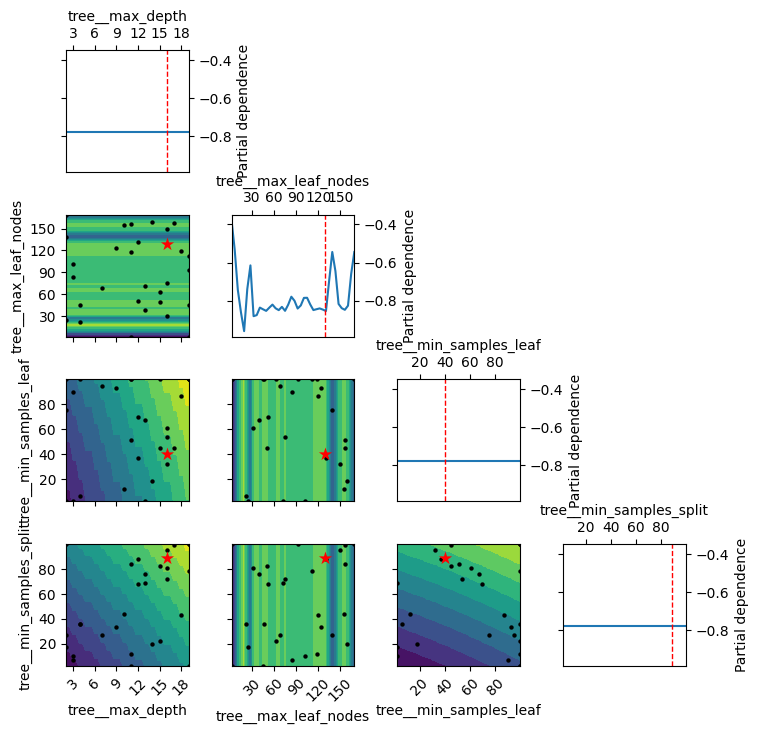

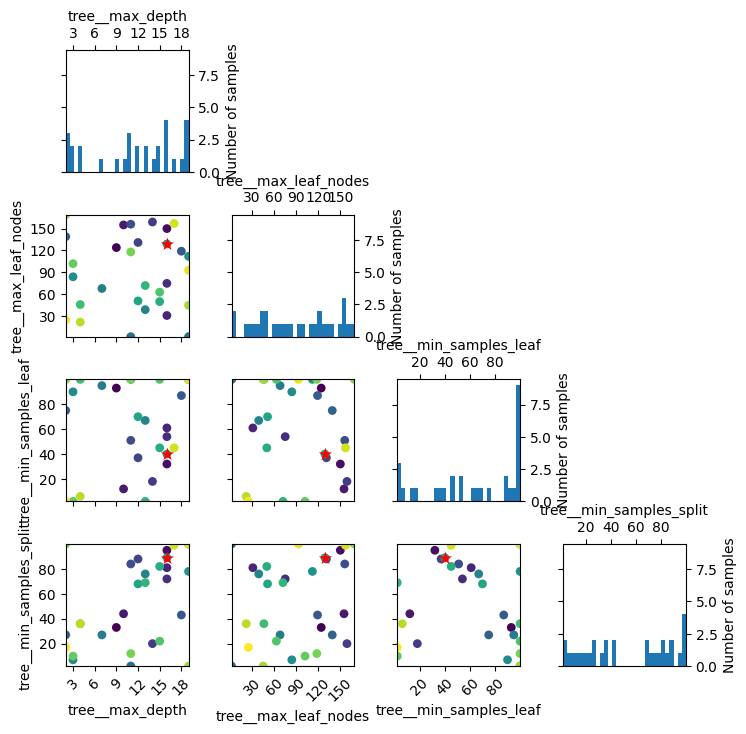

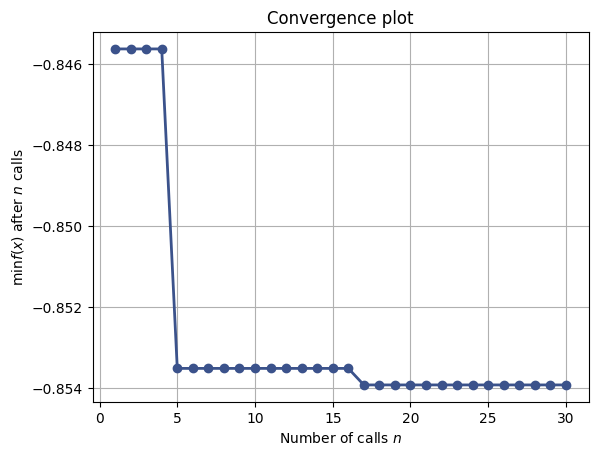

In [ ]:
plot_convergence_and_objective_function(search_tree.optimizer_results_[0])

In [ ]:
def plot_trained_tree(model, feature_names, class_names=None, size=(20,12)):
  plt.figure(figsize=size)
  plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True, precision=2, proportion=True, fontsize=6)
  plt.show()

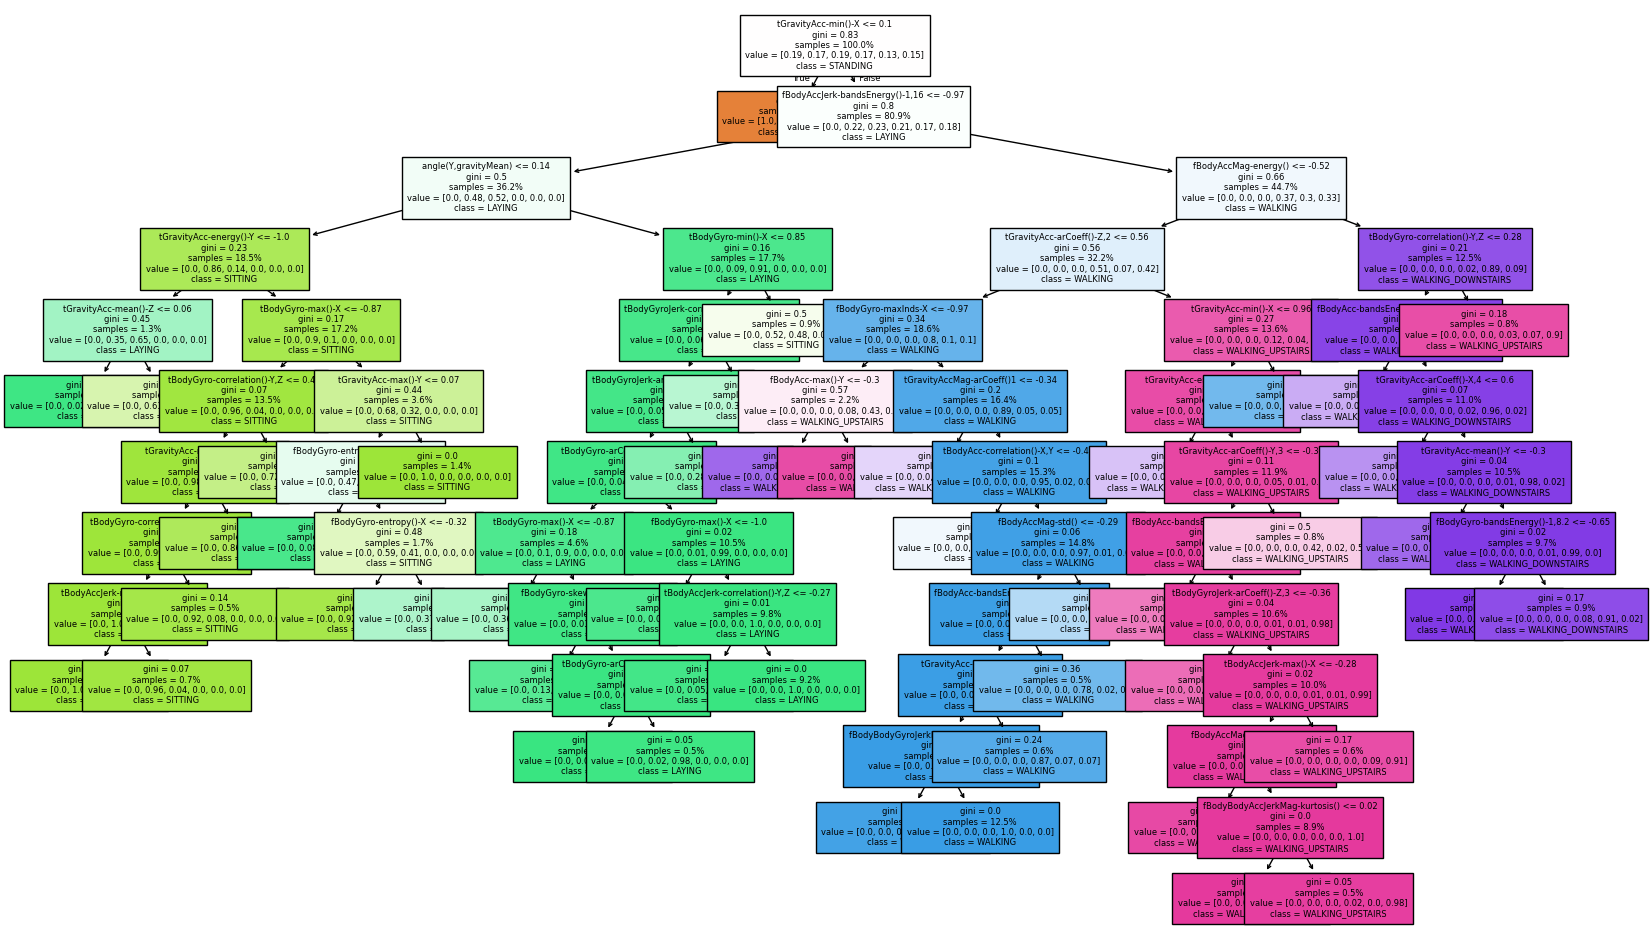

In [ ]:
plot_trained_tree(search_tree.best_estimator_['tree'], feature_names=X_train.columns, class_names=y_train.unique())

## Árbol con optimización de hiperparámetros

En este caso, realizaremos una búsqueda que incluya una reducción de dimensionalidad previa, así como de `max_split`, que determina el número máximo de atributos que el árbol considerará cuando realice una división.

In [ ]:
pipeline = Pipeline([
    ("dim_reduction", PCA()),
    ('tree', DecisionTreeClassifier())
])

param_grid = {
  'dim_reduction__n_components': Integer(2,251),
  'tree__max_depth' : Integer(2,maxdepth),
  'tree__max_leaf_nodes' : Integer(2,nleaves),
  'tree__min_samples_split': Integer(2, 100),
  'tree__min_samples_leaf': Integer(2, 100),
  'tree__max_features': Real(0.0001, 1) # fraction of features seen during fit to consider at each split, 0 not included
}
search_space_size(param_grid)

Size of hyperparameter space: 6788494326 possible combinations.


In [ ]:
search_tree_reduced = BayesSearchCV(
  pipeline,
  param_grid,
  n_iter=NUM_ITER,
  cv=kfold,
  random_state=STATE,
  n_jobs=-1,
  return_train_score=True
)
start = perf_counter()
search_tree_reduced.fit(X_train, y_train)
print_time(start)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Total training time:  4 min, 37.0 sec


In [ ]:
model_evaluation(search_tree_reduced.best_estimator_, X_train, y_train, X_test, y_test) # evaluar métricas del modelo
cv, df = analize_fitting_crossval(search_tree_reduced.cv_results_, top=3) # comprobar overfitting
cv

░░▒▒▓▓ Model Evaluation over Test Set ▓▓▒▒░░

Test Set Performance:
Accuracy: 0.8273
F1-Score (weighted): 0.8261

Classification Report (simplified):
                    f1-score  support
STANDING              0.9831      537
SITTING               0.7665      491
LAYING                0.8022      532
WALKING               0.8431      496
WALKING_DOWNSTAIRS    0.7500      420
WALKING_UPSTAIRS      0.7862      471
accuracy              0.8273        0
macro avg             0.8218     2947
weighted avg          0.8261     2947



mean_validation_score  mean_train_score  diff_train_validation  \
26                 0.8096            0.9672                 0.1576   
8                  0.8037            0.8795                 0.0758   
0                  0.7965            0.8603                 0.0638   

    rank_validation_score  n_components  max_depth  max_features  \
26                      1            27         19      1.000000   
8                       2           240         14      0.871665   
0                       3           104         14      0.932875   

    max_leaf_nodes  min_samples_leaf  min_samples_split  
26             162                 2                  2  
8               71                39                 23  
0               55                68                 43

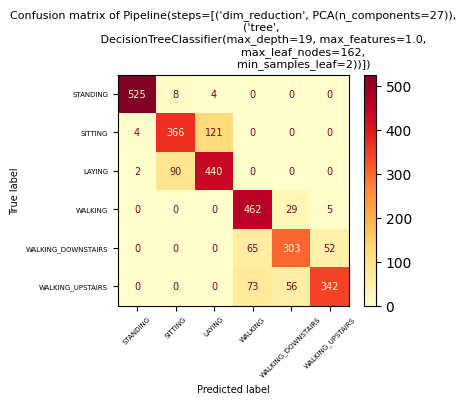

In [ ]:
show_confusion_matrix(search_tree_reduced.best_estimator_, X_train, y_train, X_test, y_test)

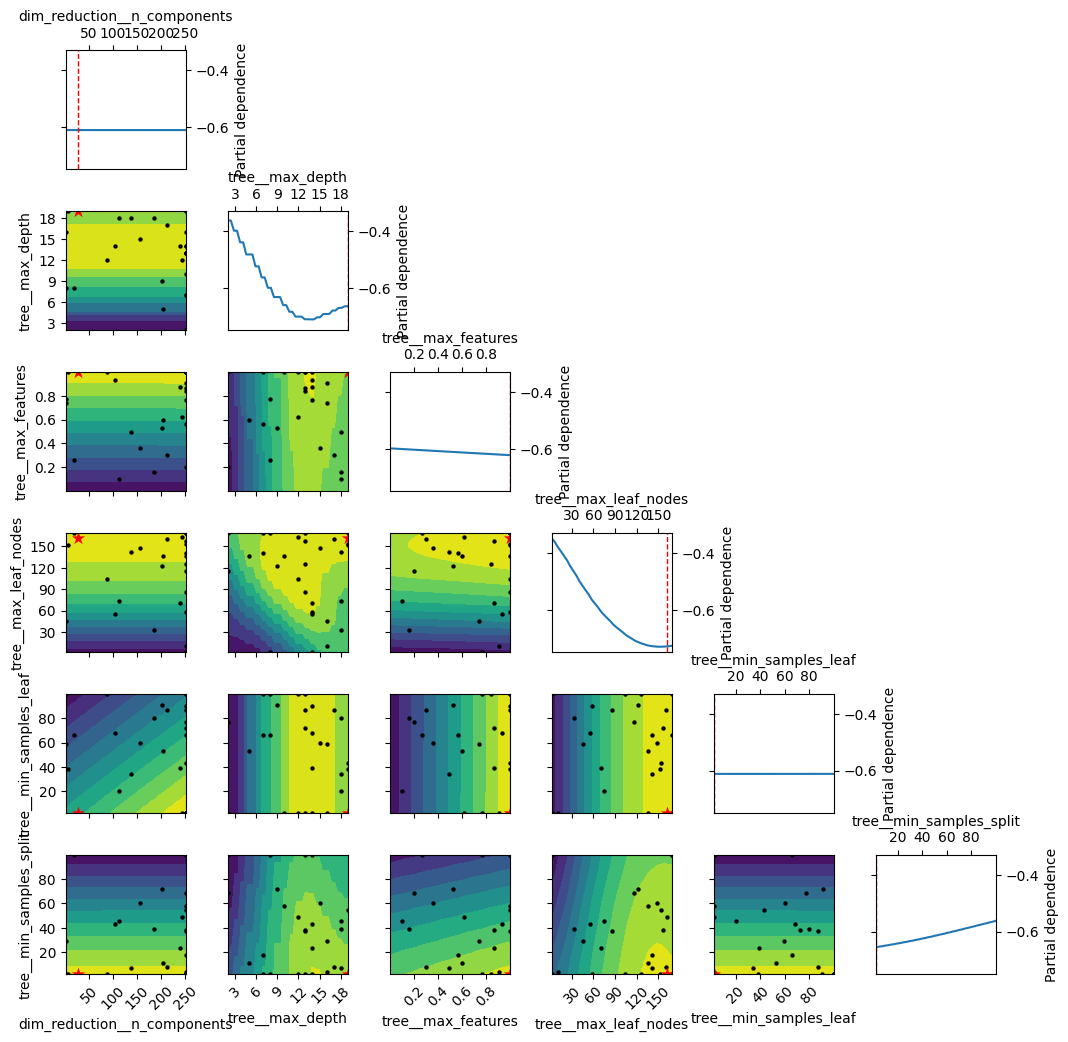

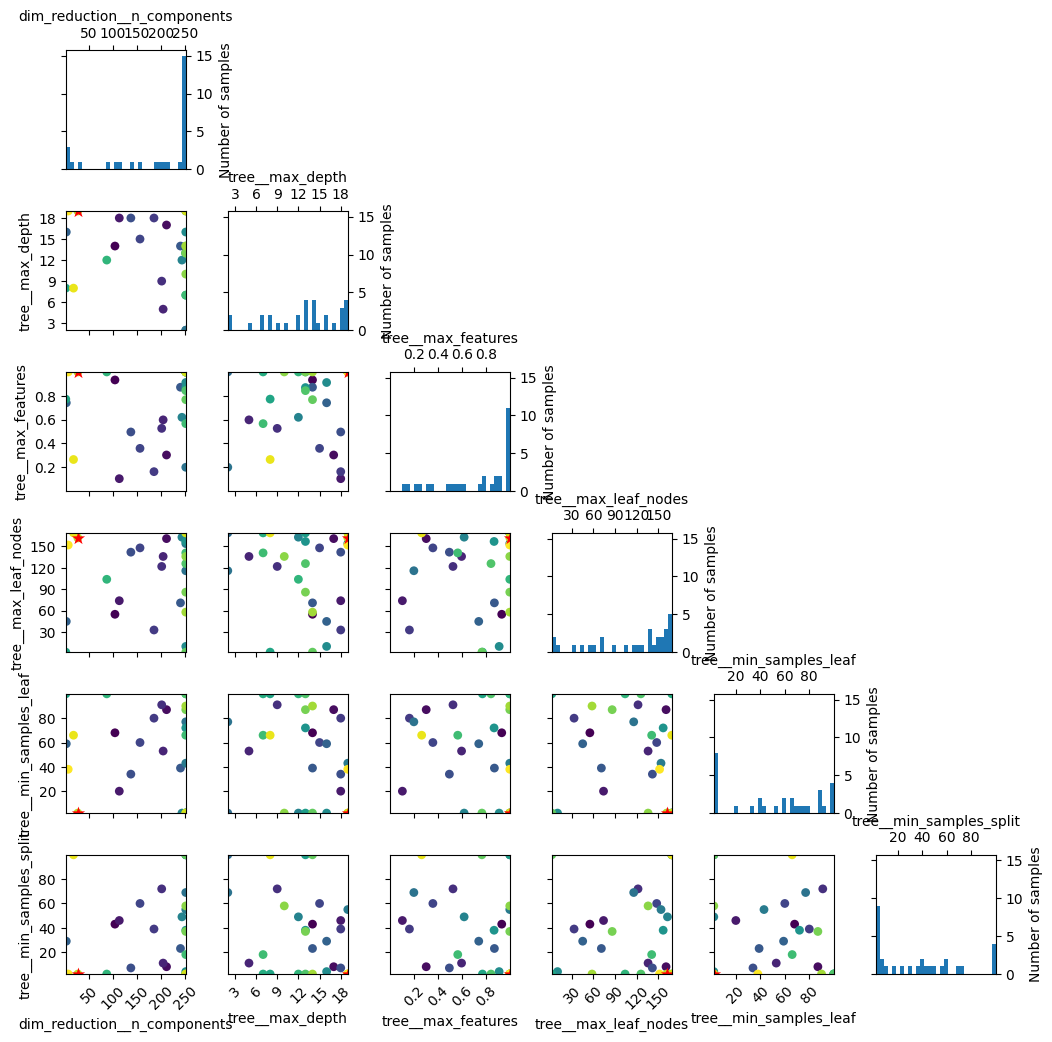

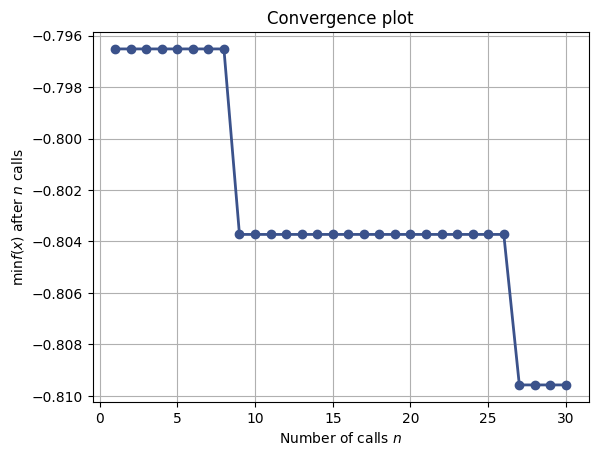

In [ ]:
plot_convergence_and_objective_function(search_tree_reduced.optimizer_results_[0])

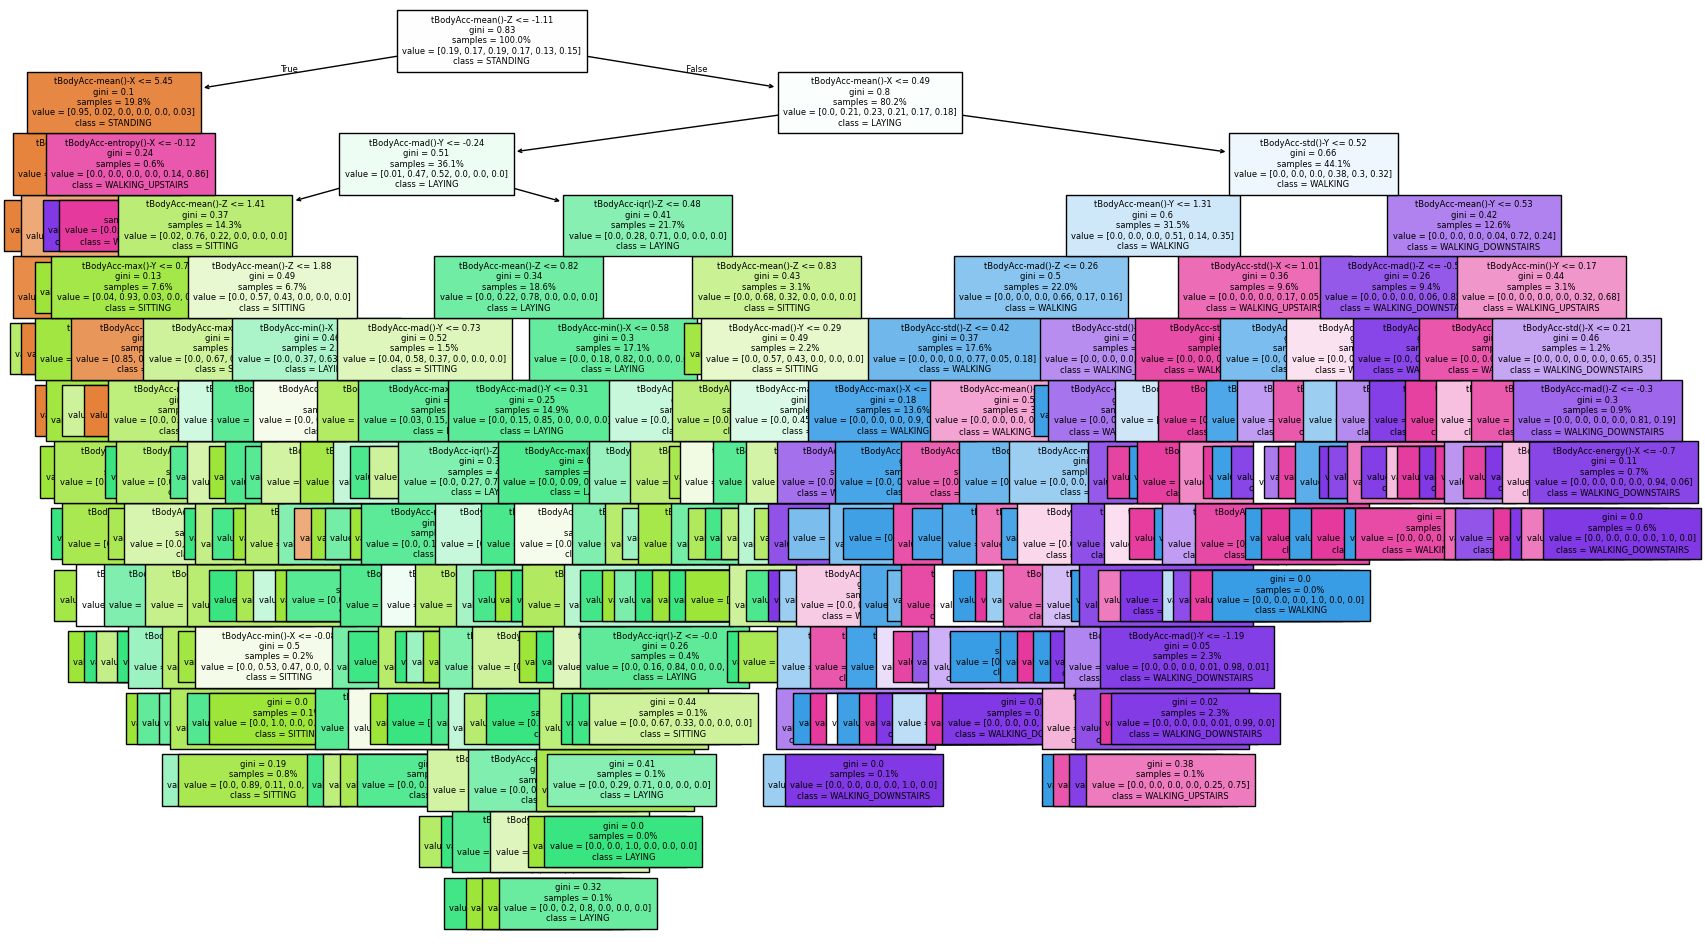

In [ ]:
plot_trained_tree(search_tree_reduced.best_estimator_['tree'], feature_names=X_train.columns, class_names=y_train.unique())

[Hyperparameter Optimization (HPO) of Machine Learning Models](https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb)

https://scikit-learn.org/1.5/auto_examples/miscellaneous/plot_pipeline_display.html

https://scikit-learn.org/1.5/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py